# Imports for project

In [123]:
# DO NOT REMOVE THESE
%load_ext autoreload
%autoreload 2
#%aimport src.base

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
# DO NOT REMOVE This
%reload_ext autoreload

In [125]:
## DO NOT REMOVE
## import local src module -
## src in this project will contain all your local code
## clean_data.py, model.py, visualize.py, custom.py
from src import clean_data as cln
from src import visualize as viz
from src import model as md
from src.clean_data import *
import io
import sys

def test_src():
    #cln.test_clean_data()
    #viz.test_viz()
    #md.test_model()
    
    return 1

test_src()


1

# Library Imports

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from sklearn import metrics
from sklearn.metrics import mean_squared_error

from datetime import datetime
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings("ignore")

# Data Importing

In [5]:
zillow_df = pd.read_csv('../data/raw/zillow_data.csv')
chicago_df = zillow_df[zillow_df['City']=='Chicago']

In [6]:
chicago_dates = chicago_df[chicago_df.columns[7:]]  # Take the dates from the 8th column onwards, drop previous columns
chicago_df = chicago_dates.T  # Transpose dataframe to put the column headings as row headings and give each date its own row.
chicago_df.reset_index(inplace=True)  # Bring the dates out of the index, so we can change their type
chicago_df['index'] = pd.to_datetime(chicago_df['index'])  # change dates to datetime

chicago_df.set_index('index', inplace=True)

chicago_zips = zillow_df['RegionName'][zillow_df['City']=='Chicago'] # Grab the Chicago zipcodes from original dataframe
chicago_df.columns = list(chicago_zips) # use Chicago's zipcodes as column headings
chicago_df.to_csv('../data/processed/chicago_jan1996_to_april2018')

chicago_df = chicago_df['2012-06':]
chicago_df.to_csv('../data/processed/chicago_june2012_to_april2018')


# Deflate Chicago Data
# New Dataframe
deflation_factors_2012_to_2019 = pd.DataFrame({'year': [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], 
                          'factor': [0.937, 0.950, 0.966, 0.967, 0.979, 1.000, 1.020, 1.042]})
# Change the year column to datetime format
deflation_factors_2012_to_2019['year'] = pd.to_datetime(deflation_factors_2012_to_2019['year'], format='%Y')
# Set the year column to be the index
deflation_factors_2012_to_2019.set_index('year', inplace=True)
# Expand dataframe to have each month of the years alongside its deflation factor
deflation_factors_2012_to_2019 = deflation_factors_2012_to_2019.resample('M').ffill()
# Take off the months we don't need for now
deflation_factors_2012_to_2018 = deflation_factors_2012_to_2019[5:-9]  # 2012-06 to 2018-04
# Change the index (dates) to datetime
deflation_factors_2012_to_2018.index = [pd.datetime(x.year, x.month, 1) for x in deflation_factors_2012_to_2018.index.tolist()]
print(deflation_factors_2012_to_2018.head(3))
print(deflation_factors_2012_to_2018.tail(3))

# Concatenate 2 dataframes
chicago_df_defl = pd.concat([chicago_df, deflation_factors_2012_to_2018], axis=1)

# Divide each price value by the corresponding CPI deflation value
for column in chicago_df_defl.columns[:-1]:
    chicago_df_defl[column] = chicago_df_defl[column].div(chicago_df_defl['factor'])

# Drop factor column
chicago_df_defl.drop('factor', axis=1, inplace=True)
chicago_df_defl.to_csv('../data/processed/chicago_june2012_to_april2018_deflated')
#chicago_df_defl.isna().sum().sort_values(ascending=False).head(3)

            factor
2012-06-01   0.937
2012-07-01   0.937
2012-08-01   0.937
            factor
2018-02-01    1.02
2018-03-01    1.02
2018-04-01    1.02


In [7]:
chicago_df = pd.read_csv('../data/processed/chicago_jan1996_to_april2018', index_col='index' )

## Initial Visualization

### Check the trend 1996-2018

In [8]:
# Build a DataFrame with the date alongside the mean of all the median chicago house prices
chicago_df_mean = np.mean(chicago_df, axis=1)
# chicago_dates_list = pd.to_datetime(list(chicago_dates.columns)) # date column
# chicago_dates_mean = list(chicago_df.mean(axis=1))  # mean column

# chicago_df_mean = pd.DataFrame({'date': chicago_dates_list, 'mean': chicago_dates_mean})
# chicago_df_mean.head(3)
chicago_df_mean = chicago_df_mean.reset_index()
chicago_df_mean.columns = ['date', 'mean']
chicago_df_mean['date']=  pd.to_datetime(chicago_df_mean['date'])

#### Visualize 1996-2018 mean trend

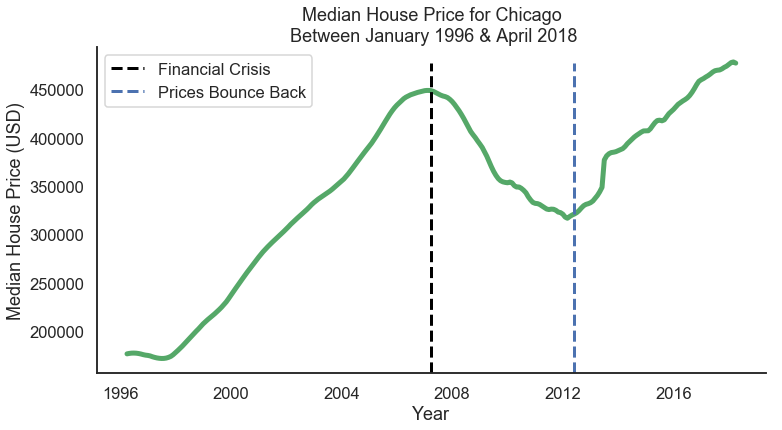

In [9]:
# Set figuresize and style
sns.set(rc={'figure.figsize':(12,6)},style="white", context="talk")

# Plot
    # Data
ax = sns.lineplot('date', 'mean', data=chicago_df_mean, color='g', lw=5);
    # Financial crisis vertical line
ax.axvline(x='2007-04', ymin=0, ymax=0.95, ls= "--", lw=3, color='black', label='Financial Crisis')
    # Upward trend vertical line
ax.axvline(x='2012-06', ymin=0, ymax=0.95, ls= "--", lw=3, color='b', label='Prices Bounce Back')

# Formatting
    # Title
title = 'Median House Price for Chicago\n Between January 1996 & April 2018'
ax.set_title(title)
    # Axis labels
xlabel = 'Year'
ylabel = "Median House Price (USD)"
ax.set(xlabel=xlabel, ylabel=ylabel)
    # Take off the border
sns.despine()
    # Show legend
plt.legend();

# Save the model as a png file
plt.savefig('../reports/figures/chicago_price_over_time_with_cutoffs.png', bbox_inches='tight')

* We can see from the chart that the house prices fall dramatically in 2007, due to the financial crisis.
* The house prices begin to bounce back in June 2012
* Due to the limitations in an ARIMA model, we decide to cut our dataset to be from June 2012 onwards

# Transformation

## Train-Test split

In [10]:
# chicago_df_defl = pd.read_csv('../data/processed/chicago_june2012_to_april2018_deflated', index_col = ['Unnamed: 0'])
chicago_df_defl_train = chicago_df_defl.loc['2012-06':'2017-10',:] # 5 years 4 months for train data
chicago_df_defl_test = chicago_df_defl.loc['2017-11':'2018-04',:] # 6 months for test data

## Testing each Zipcode for stationarity

### Plots of zipcodes' original price with rolling mean, with Dickey Fuller test results

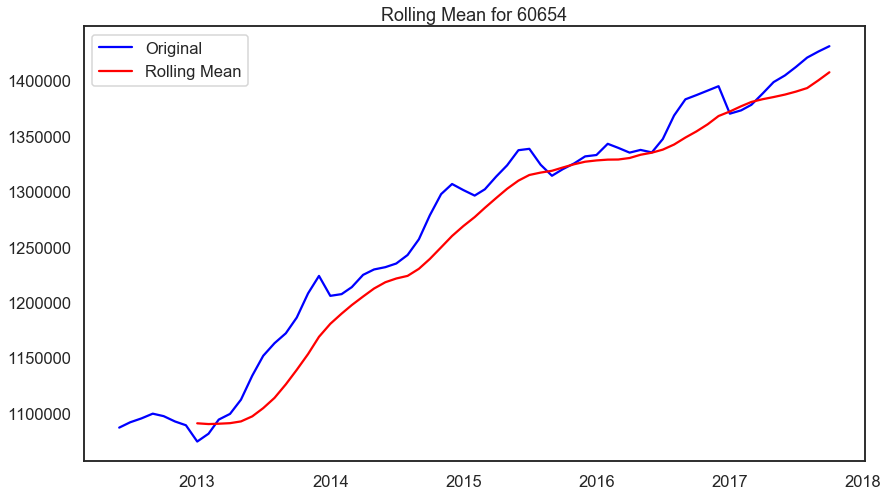

Results of Dickey-Fuller Test:
Test Statistic                 -0.802033
p-value                         0.818524
#Lags Used                      2.000000
Number of Observations Used    62.000000
Critical Value 1%              -3.540523
Critical Value 5%              -2.909427
Critical Value 10%             -2.592314
dtype: float64


In [15]:
viz.stationarity_check(chicago_df_defl_train,60654, plot_std=False)

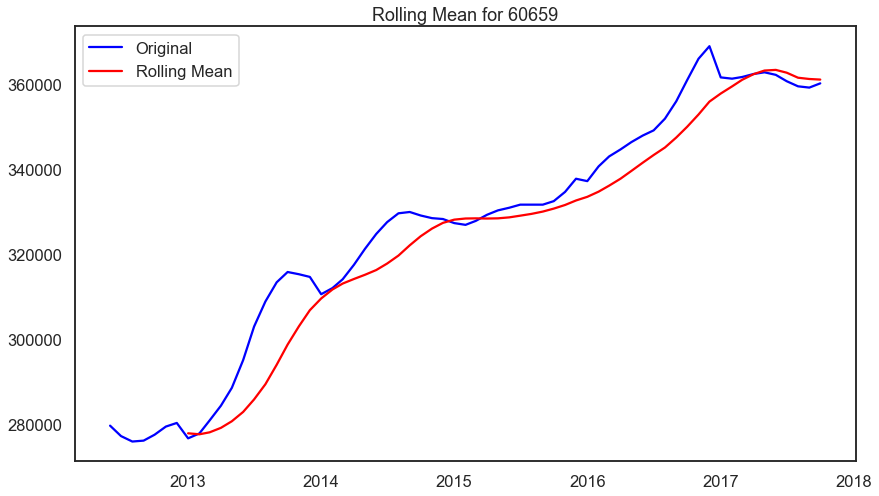

Results of Dickey-Fuller Test:
Test Statistic                 -1.600722
p-value                         0.483231
#Lags Used                      1.000000
Number of Observations Used    63.000000
Critical Value 1%              -3.538695
Critical Value 5%              -2.908645
Critical Value 10%             -2.591897
dtype: float64


In [16]:
viz.stationarity_check(chicago_df_defl_train,60659, plot_std=False)

## Removing Trends

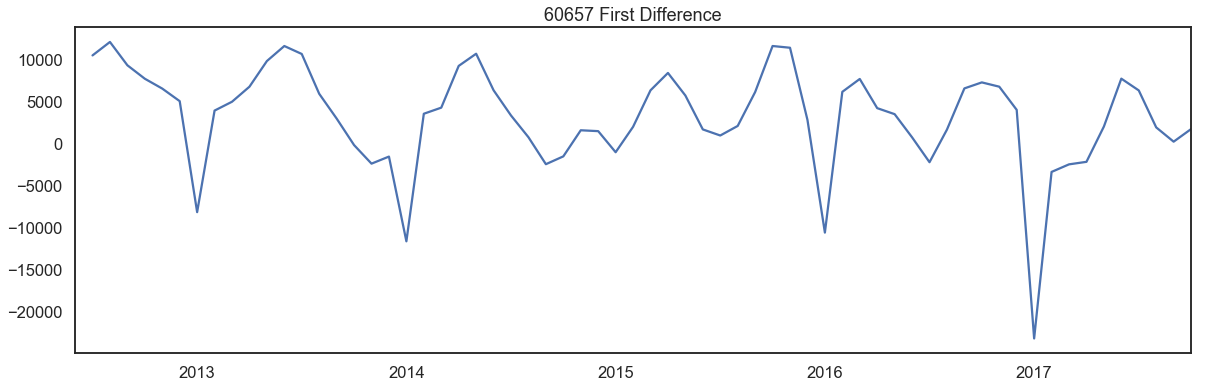

Test Statistic                 -5.168054
p-value                         0.000010
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


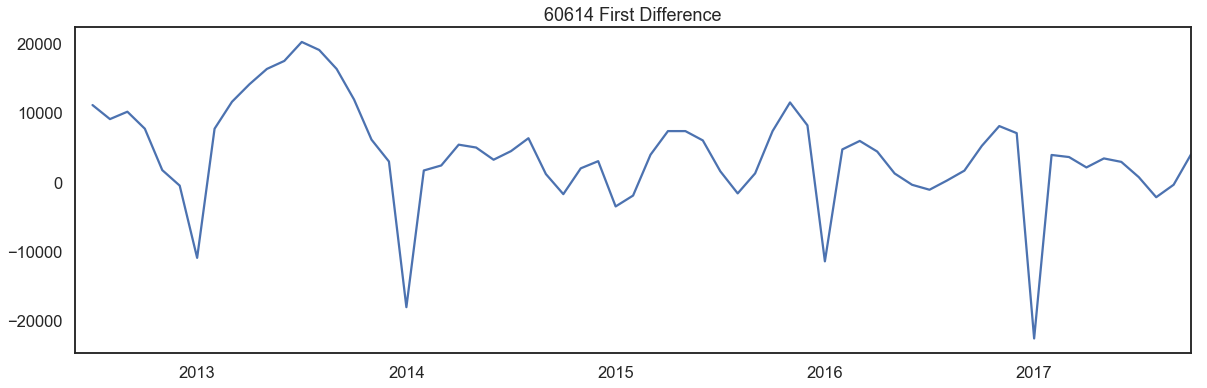

Test Statistic                 -5.029957
p-value                         0.000019
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


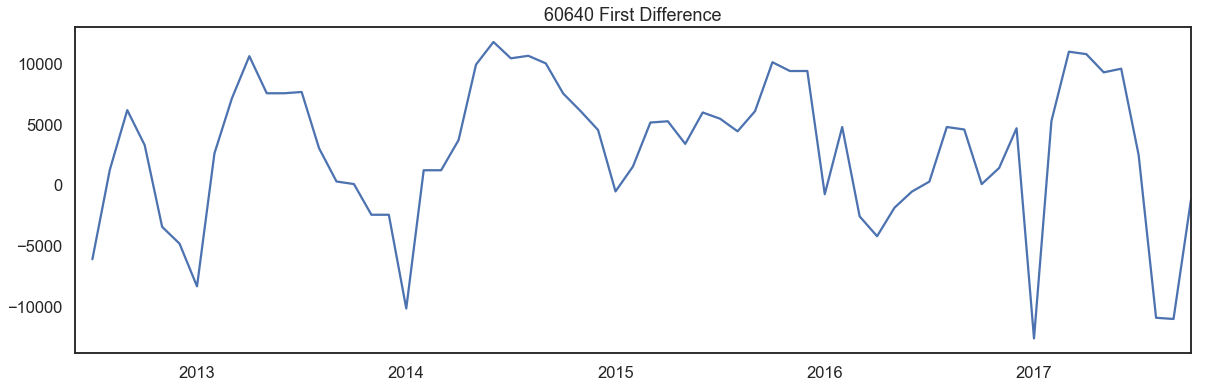

Test Statistic                 -4.159778
p-value                         0.000770
#Lags Used                      3.000000
Number of Observations Used    60.000000
Critical Values 1%             -3.544369
Critical Values 5%             -2.911073
Critical Values 10%            -2.593190
dtype: float64


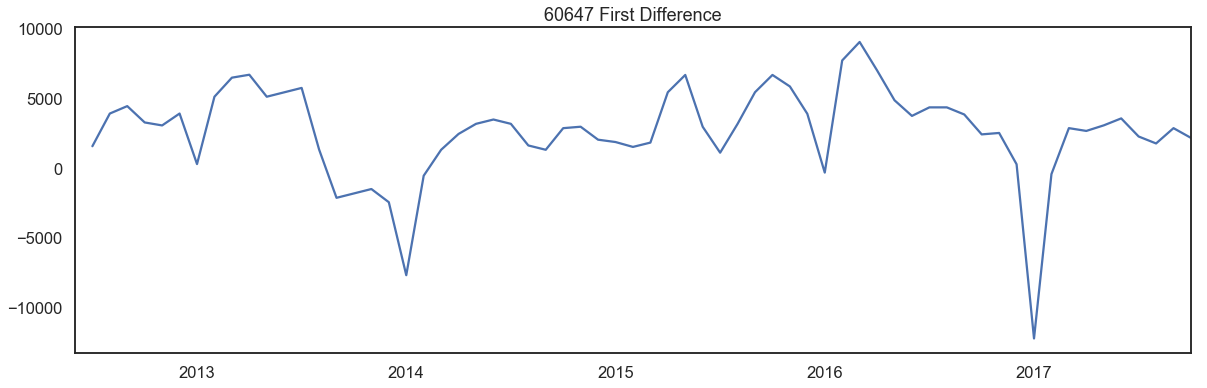

Test Statistic                 -4.232260
p-value                         0.000581
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


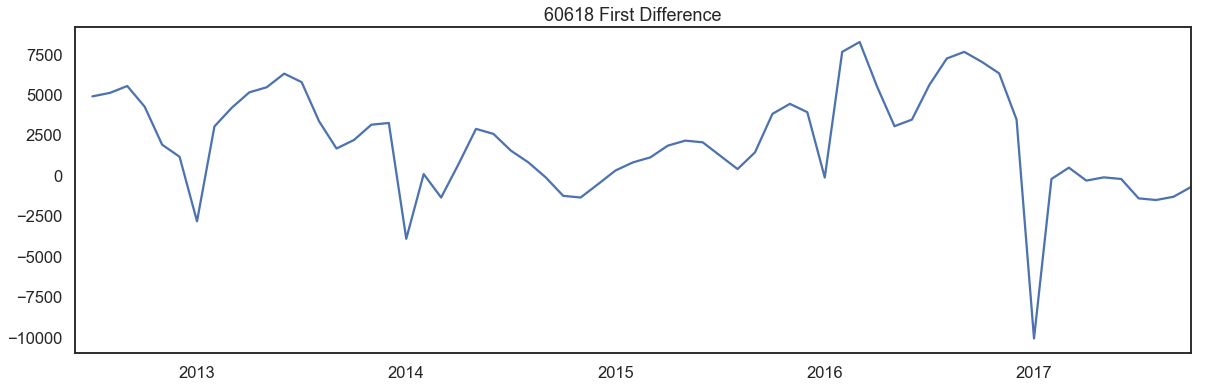

Test Statistic                 -4.090841
p-value                         0.001003
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


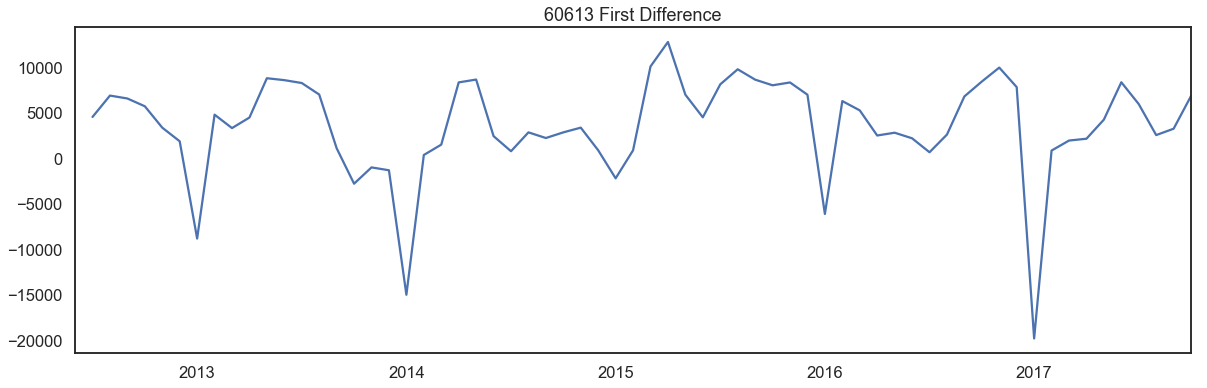

Test Statistic                -5.740825e+00
p-value                        6.281571e-07
#Lags Used                     0.000000e+00
Number of Observations Used    6.300000e+01
Critical Values 1%            -3.538695e+00
Critical Values 5%            -2.908645e+00
Critical Values 10%           -2.591897e+00
dtype: float64


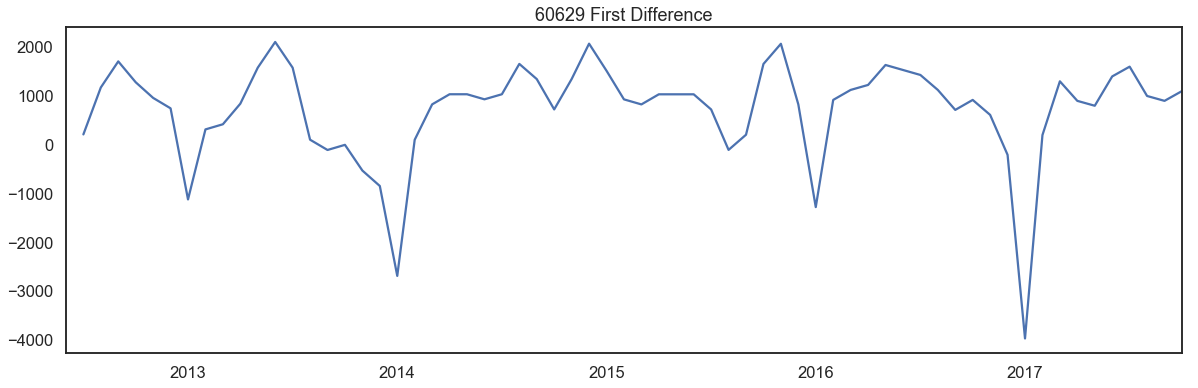

Test Statistic                 -4.873208
p-value                         0.000039
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


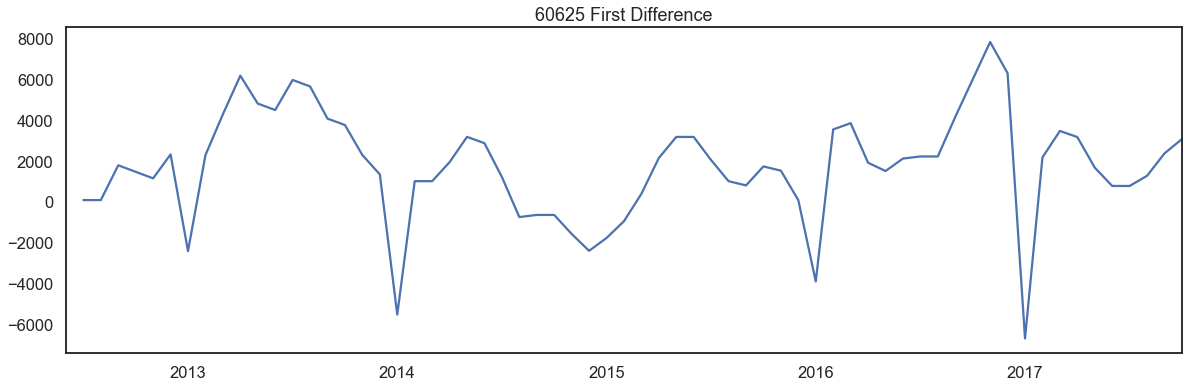

Test Statistic                 -5.052326
p-value                         0.000017
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


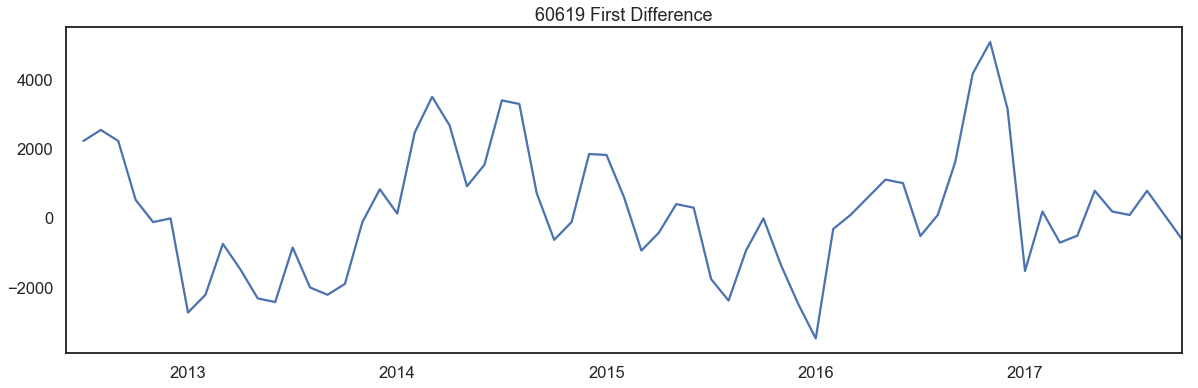

Test Statistic                 -2.981507
p-value                         0.036658
#Lags Used                      2.000000
Number of Observations Used    61.000000
Critical Values 1%             -3.542413
Critical Values 5%             -2.910236
Critical Values 10%            -2.592745
dtype: float64


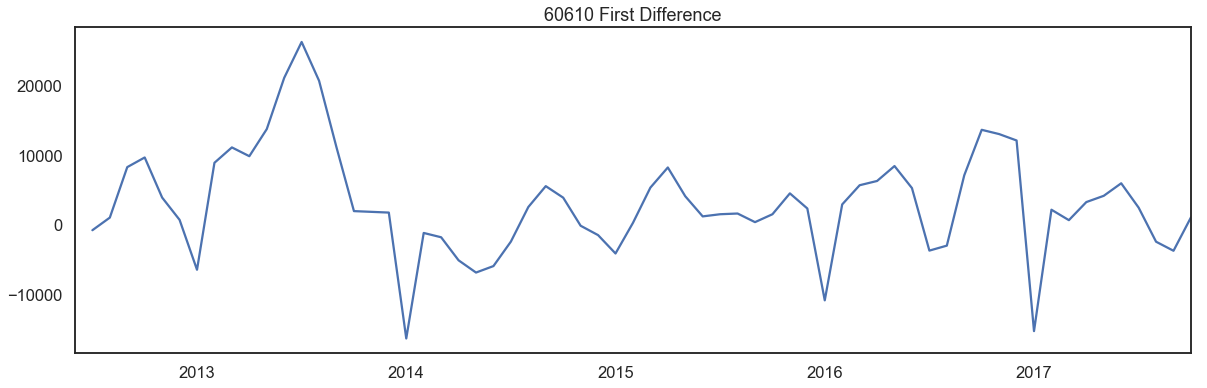

Test Statistic                 -4.177389
p-value                         0.000719
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


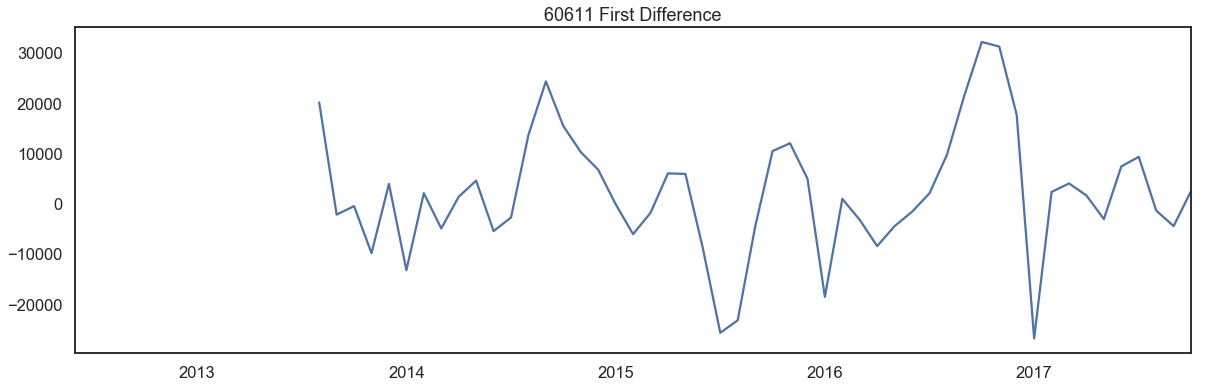

Test Statistic                 -4.157909
p-value                         0.000776
#Lags Used                      1.000000
Number of Observations Used    49.000000
Critical Values 1%             -3.571472
Critical Values 5%             -2.922629
Critical Values 10%            -2.599336
dtype: float64


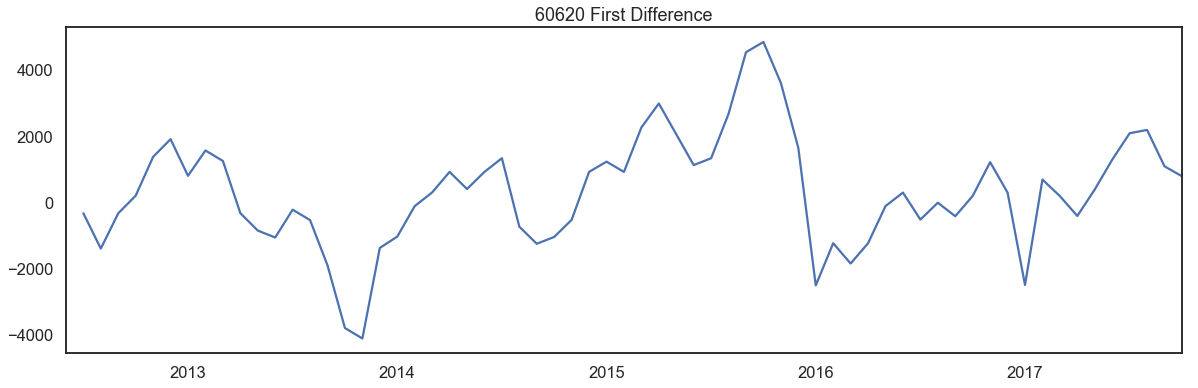

Test Statistic                 -3.602245
p-value                         0.005718
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64


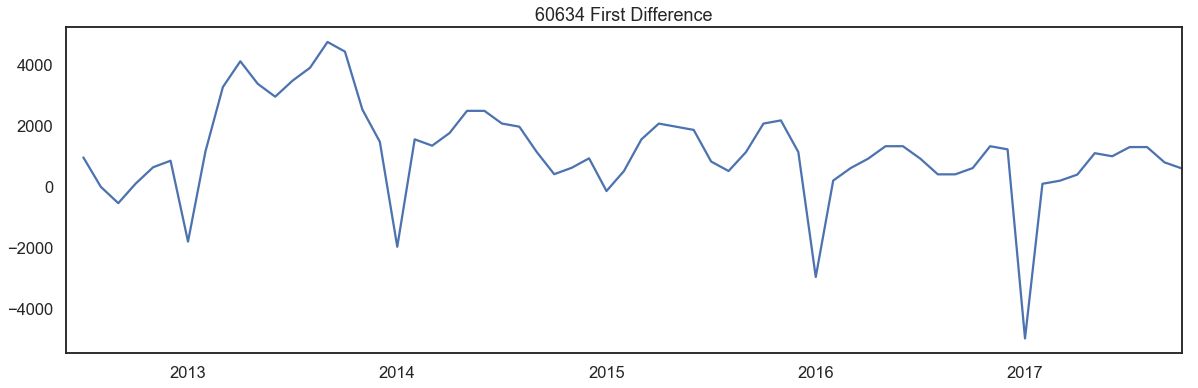

Test Statistic                 -4.470350
p-value                         0.000222
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


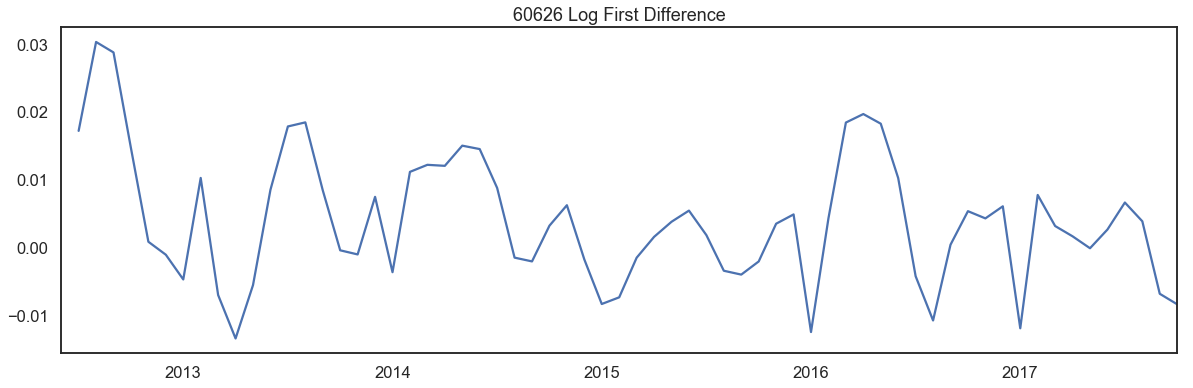

Test Statistic                 -5.333934
p-value                         0.000005
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64


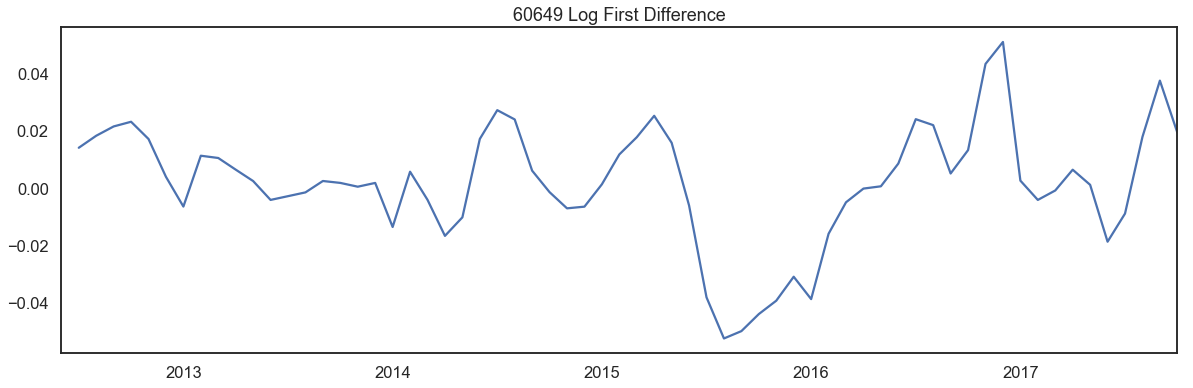

Test Statistic                 -3.052859
p-value                         0.030244
#Lags Used                      4.000000
Number of Observations Used    59.000000
Critical Values 1%             -3.546395
Critical Values 5%             -2.911939
Critical Values 10%            -2.593652
dtype: float64


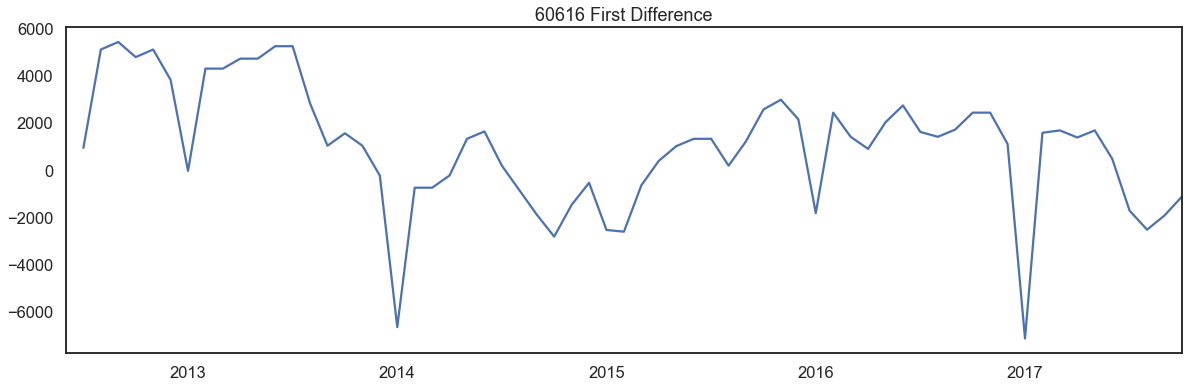

Test Statistic                 -3.989012
p-value                         0.001469
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


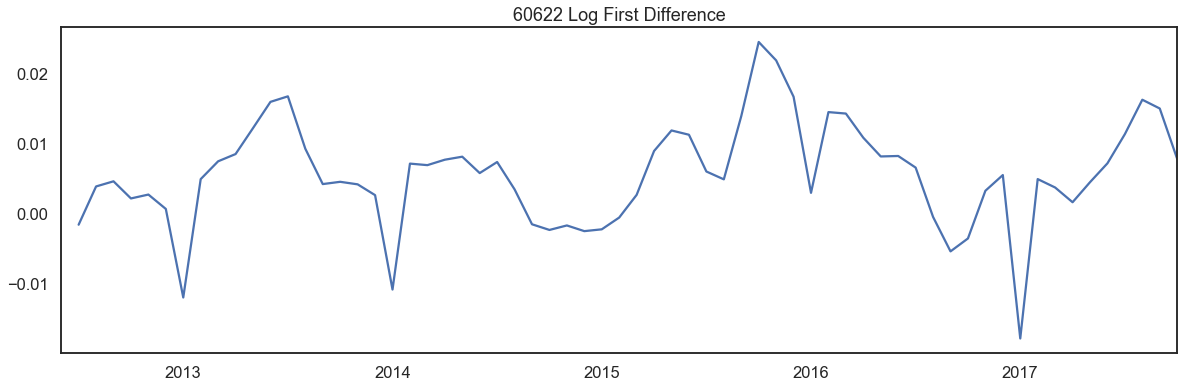

Test Statistic                 -4.262124
p-value                         0.000516
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


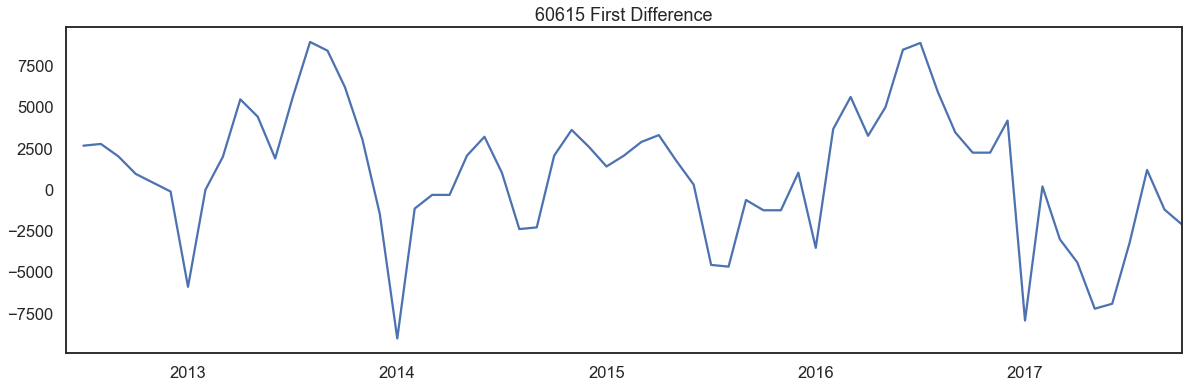

Test Statistic                 -3.721308
p-value                         0.003823
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


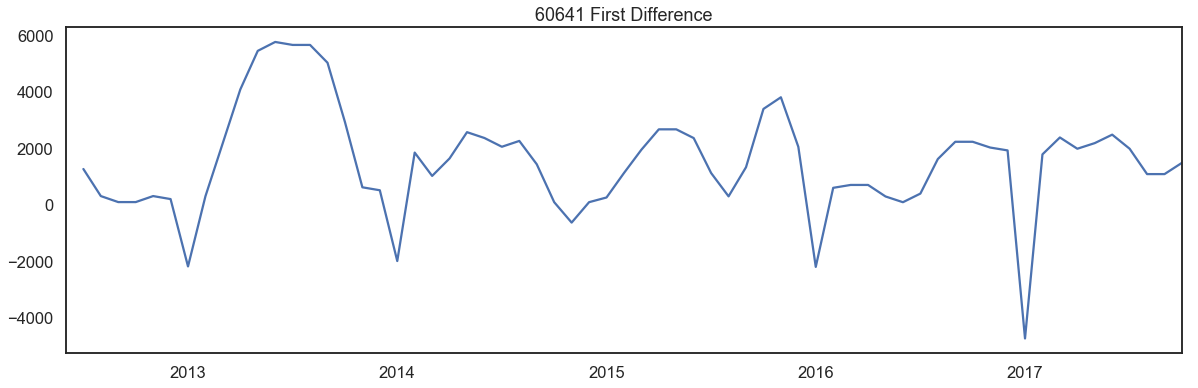

Test Statistic                 -4.088015
p-value                         0.001014
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


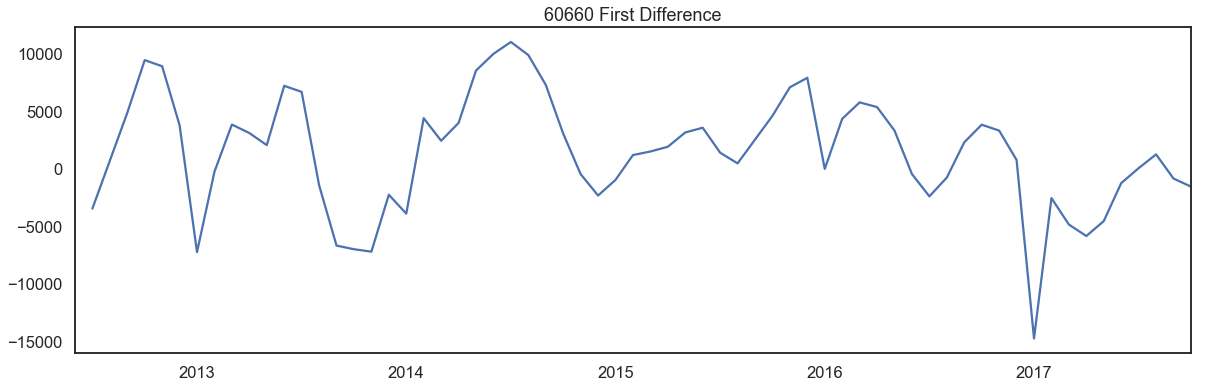

Test Statistic                 -3.782959
p-value                         0.003087
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


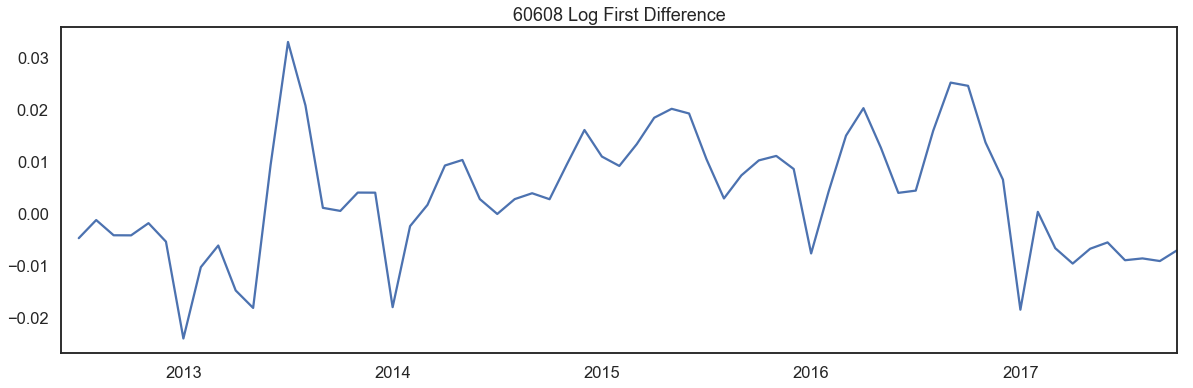

Test Statistic                 -3.949126
p-value                         0.001702
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64


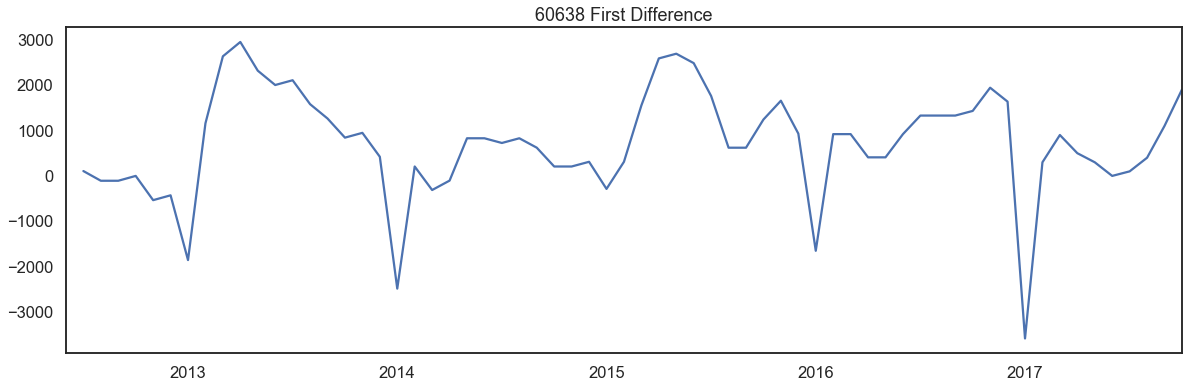

Test Statistic                 -4.837841
p-value                         0.000046
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


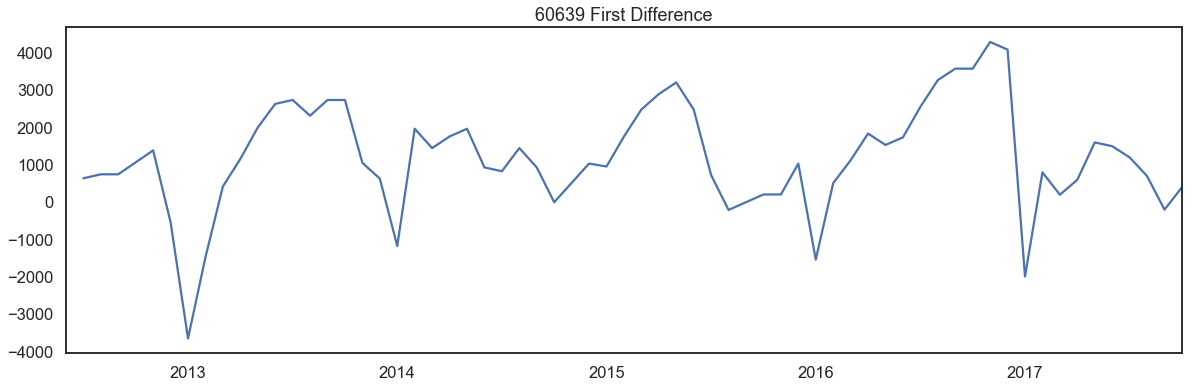

Test Statistic                 -4.063731
p-value                         0.001111
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


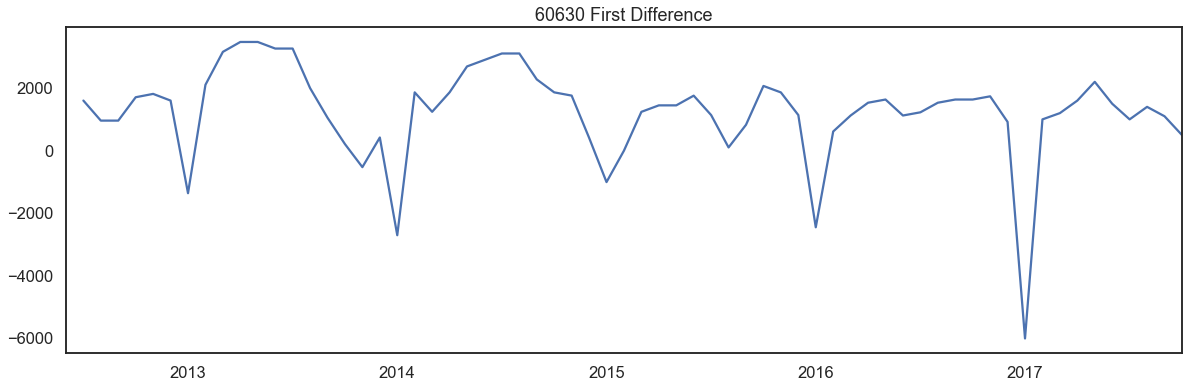

Test Statistic                 -5.528155
p-value                         0.000002
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


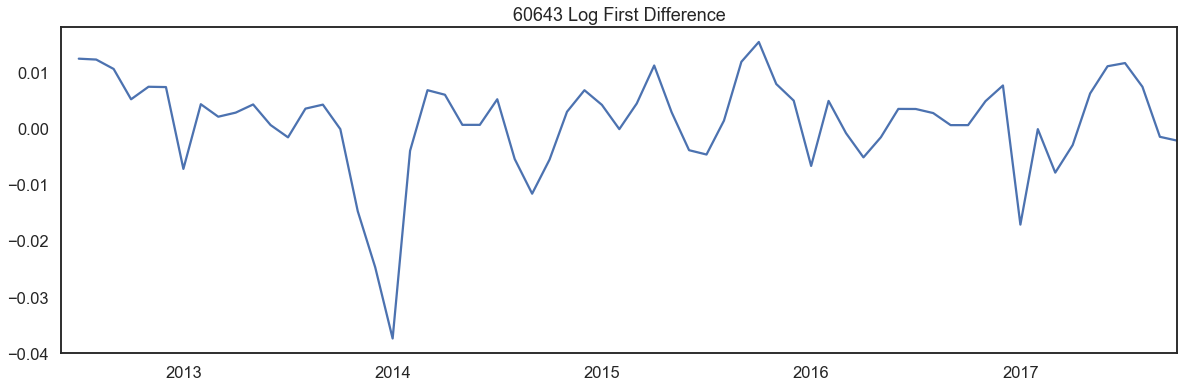

Test Statistic                 -4.724760
p-value                         0.000076
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64


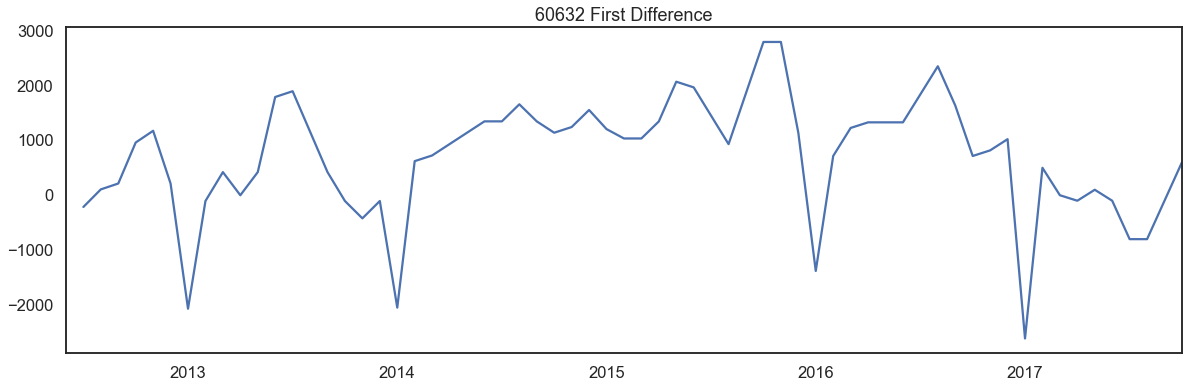

Test Statistic                 -4.484423
p-value                         0.000210
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


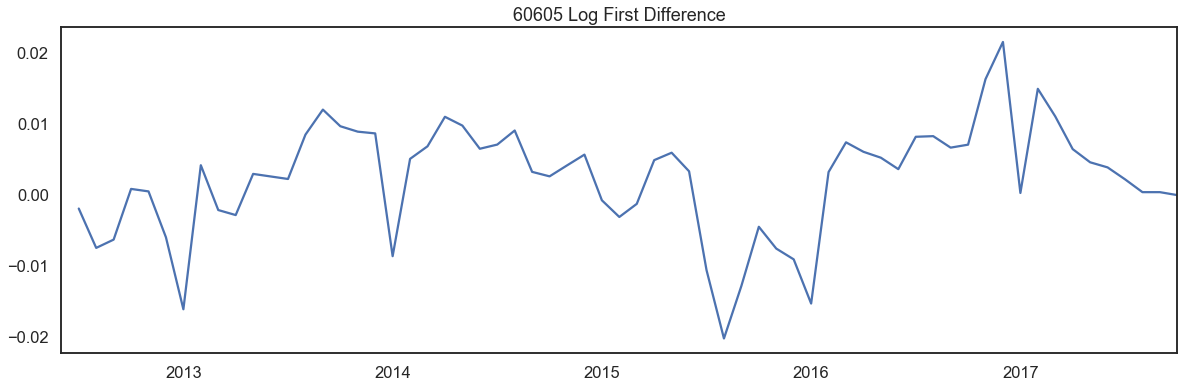

Test Statistic                 -3.938745
p-value                         0.001768
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


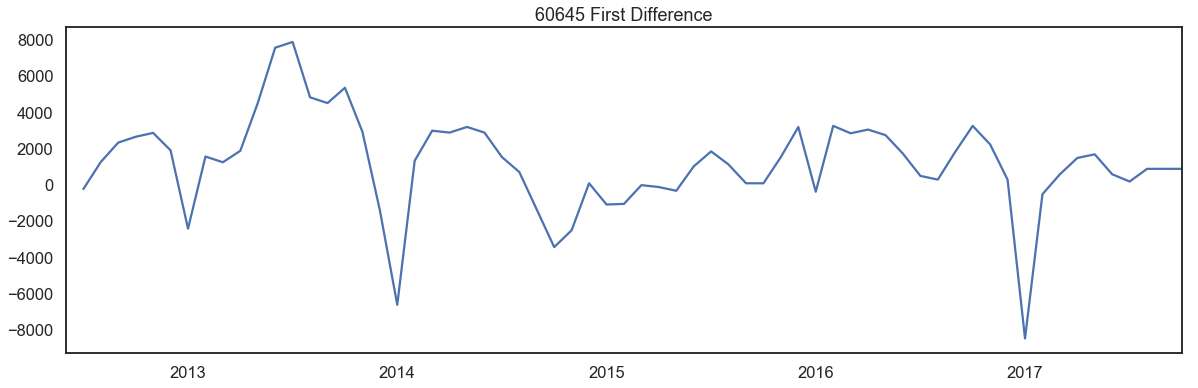

Test Statistic                 -4.287375
p-value                         0.000467
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


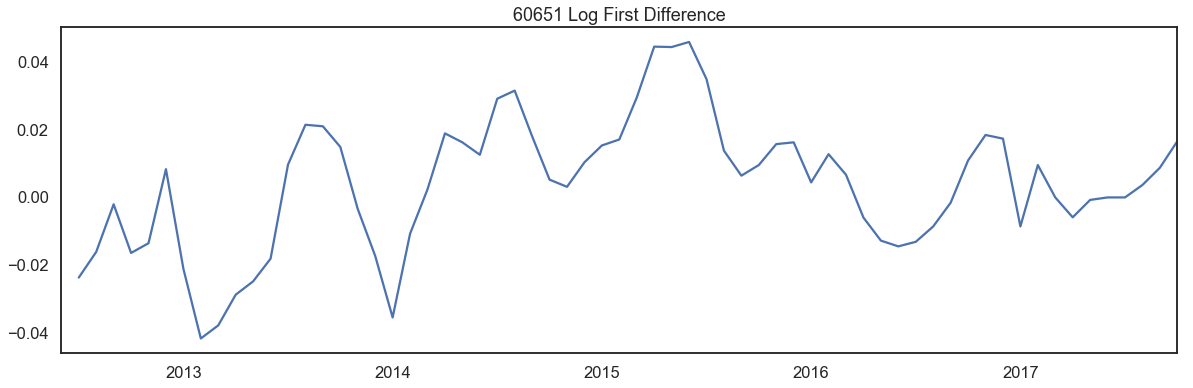

Test Statistic                 -3.311915
p-value                         0.014354
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64


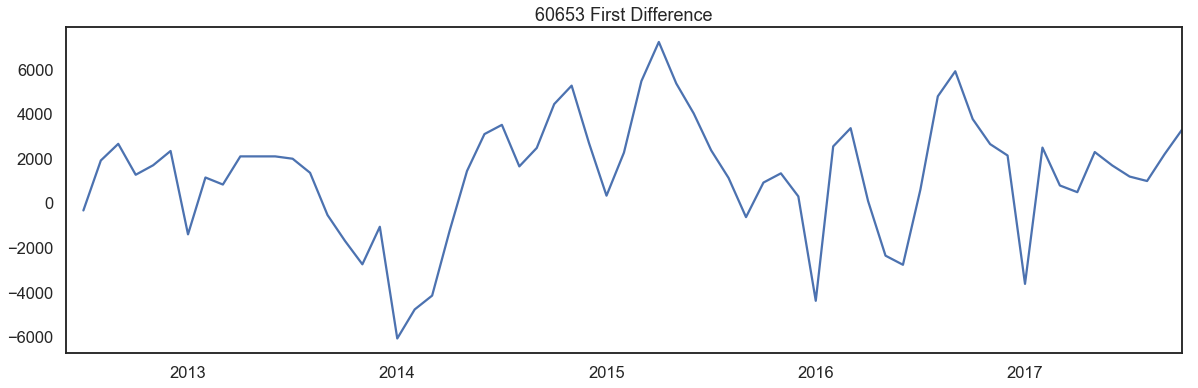

Test Statistic                 -3.823292
p-value                         0.002678
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


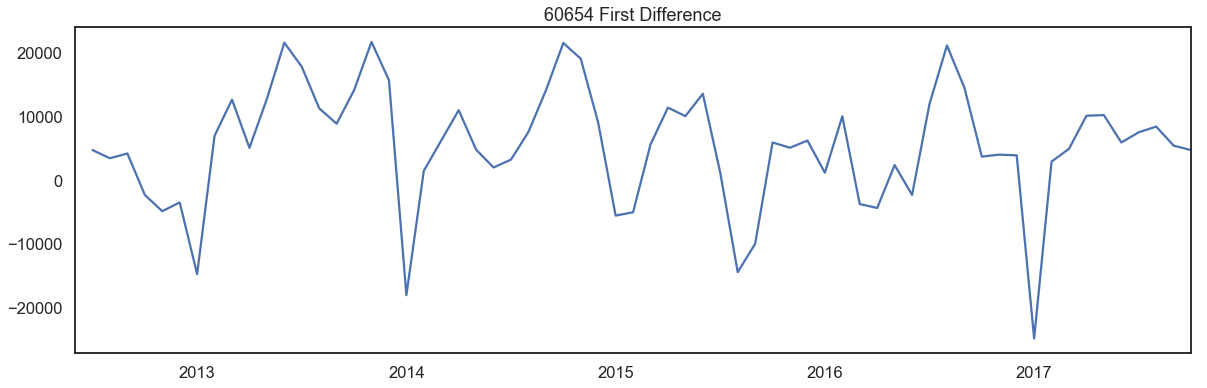

Test Statistic                 -5.085669
p-value                         0.000015
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64


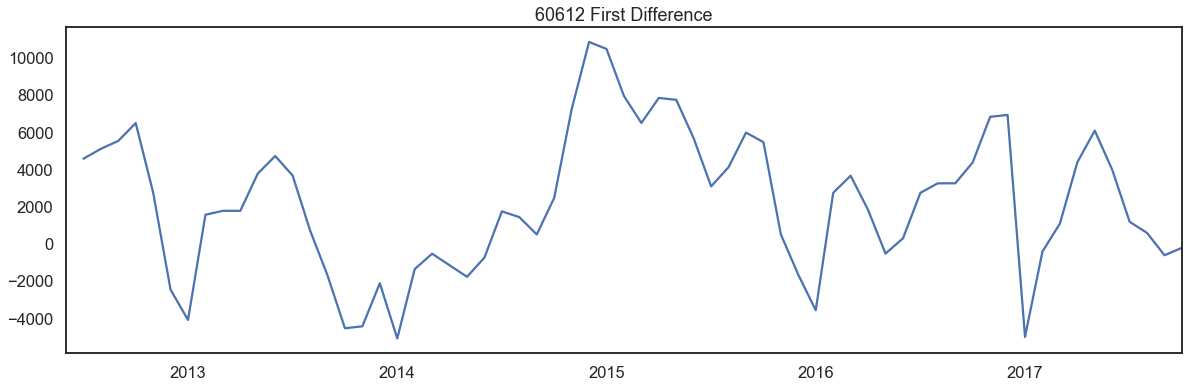

Test Statistic                 -3.737266
p-value                         0.003618
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64


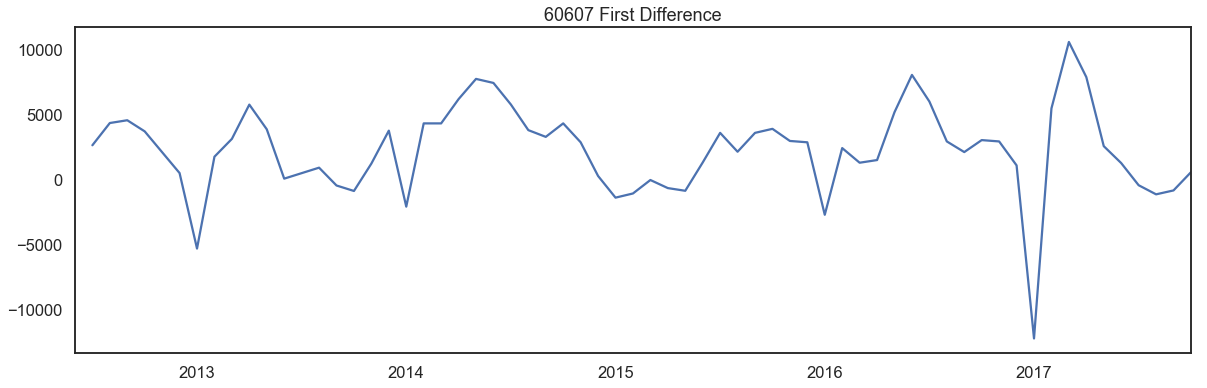

Test Statistic                 -5.204733
p-value                         0.000009
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


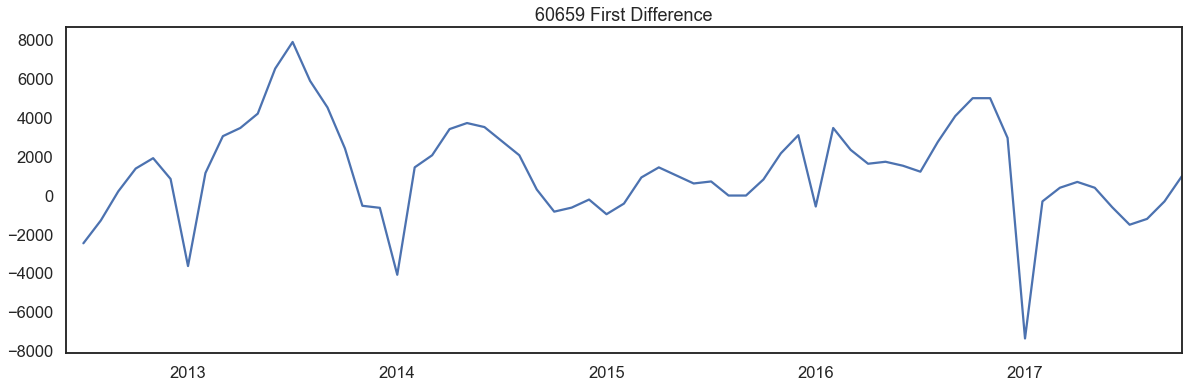

Test Statistic                 -4.273585
p-value                         0.000493
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


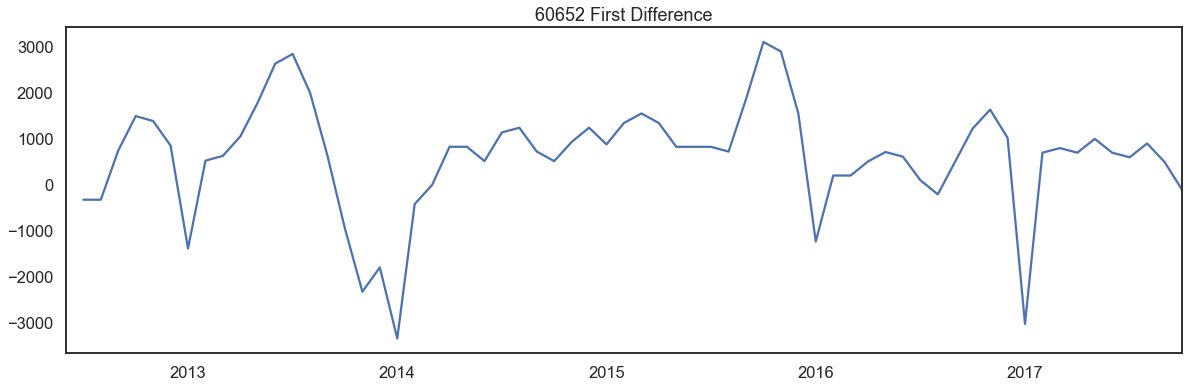

Test Statistic                 -4.193289
p-value                         0.000676
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


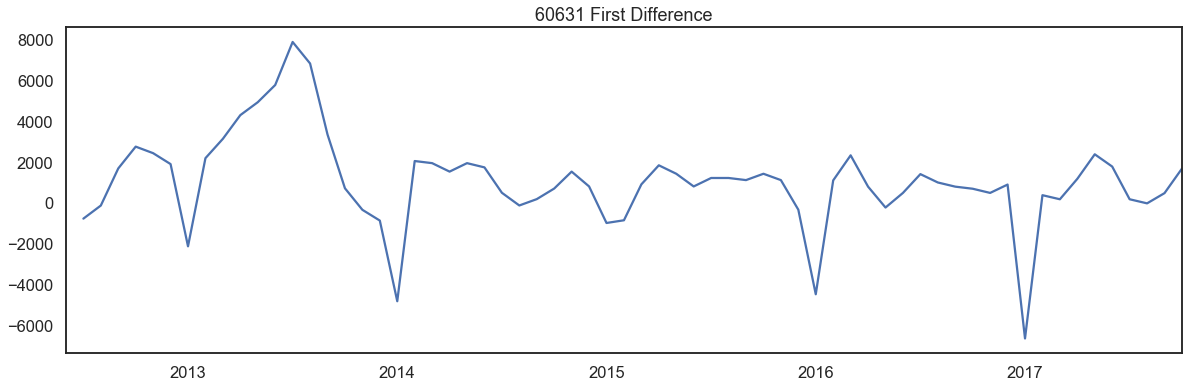

Test Statistic                 -4.546684
p-value                         0.000162
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


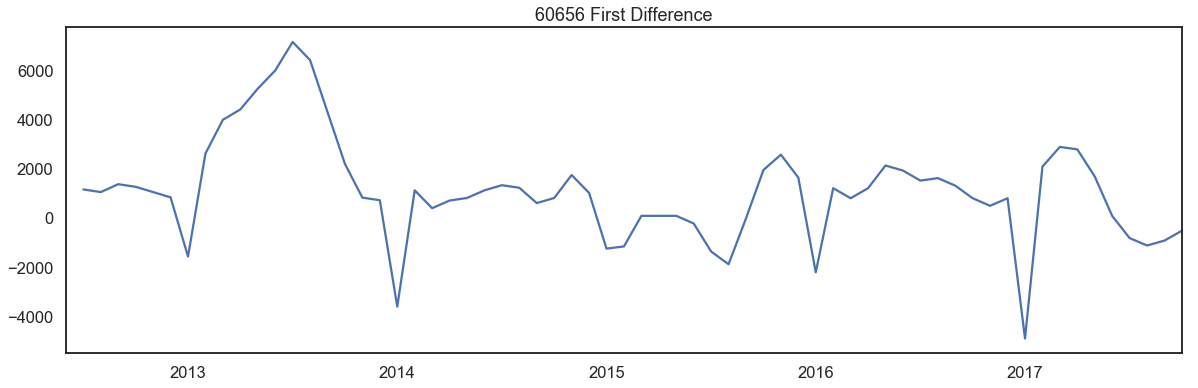

Test Statistic                 -3.786009
p-value                         0.003054
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


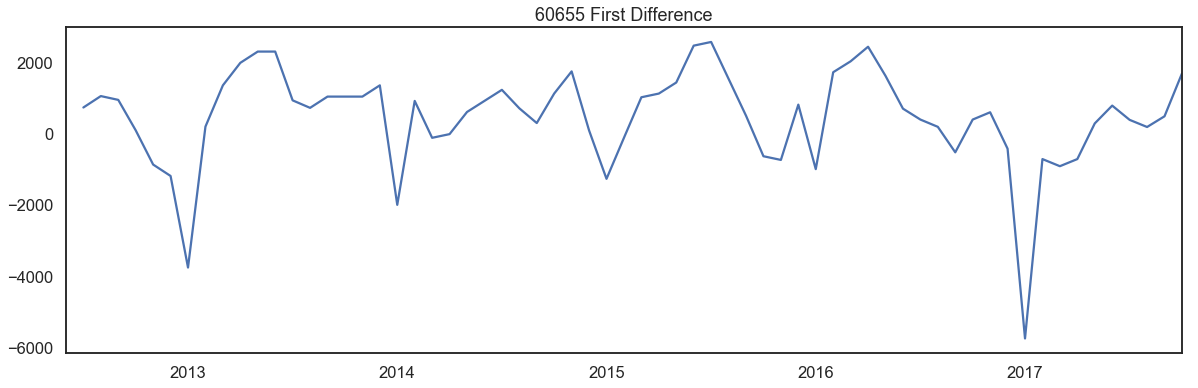

Test Statistic                 -4.883776
p-value                         0.000038
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


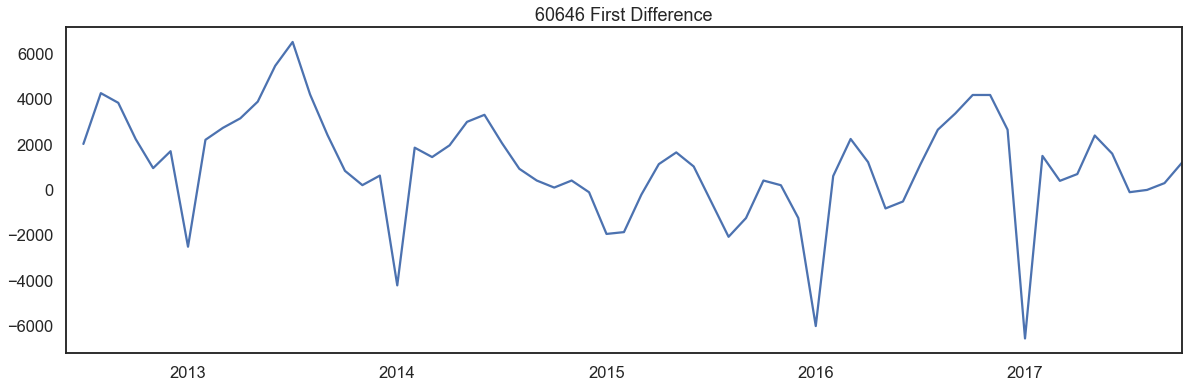

Test Statistic                 -4.891457
p-value                         0.000036
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


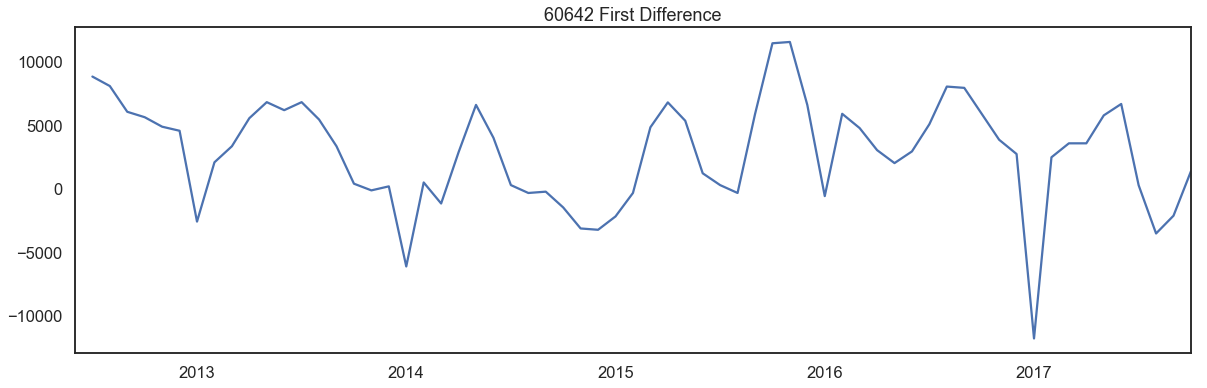

Test Statistic                 -4.468587
p-value                         0.000224
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


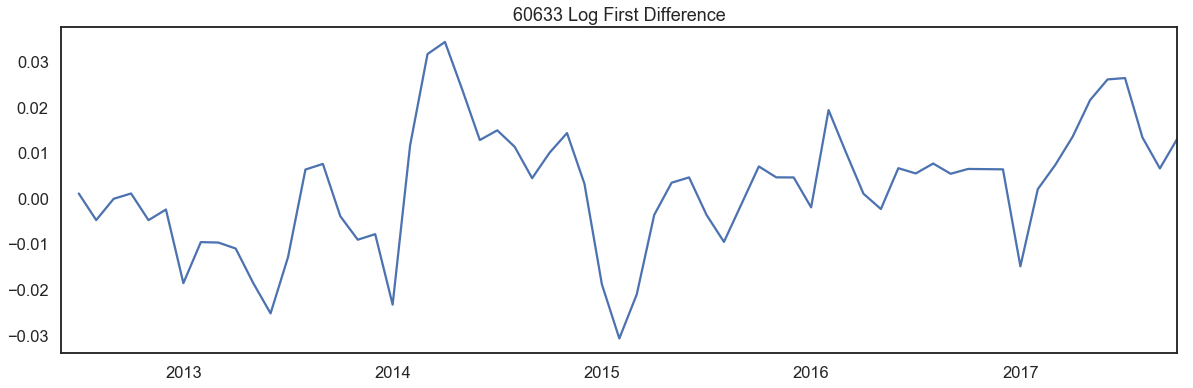

Test Statistic                 -3.909838
p-value                         0.001964
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64

Number of p-values above alpha of 0.05: 0

Zipcodes with p-values above alpha of 0.05 []

Zipcodes requiring log first difference transformation: [60626, 60649, 60622, 60608, 60643, 60605, 60651, 60633]


In [41]:
chicago_df_defl_train_dt, log_diff_list = detrend_test(chicago_df_defl_train)


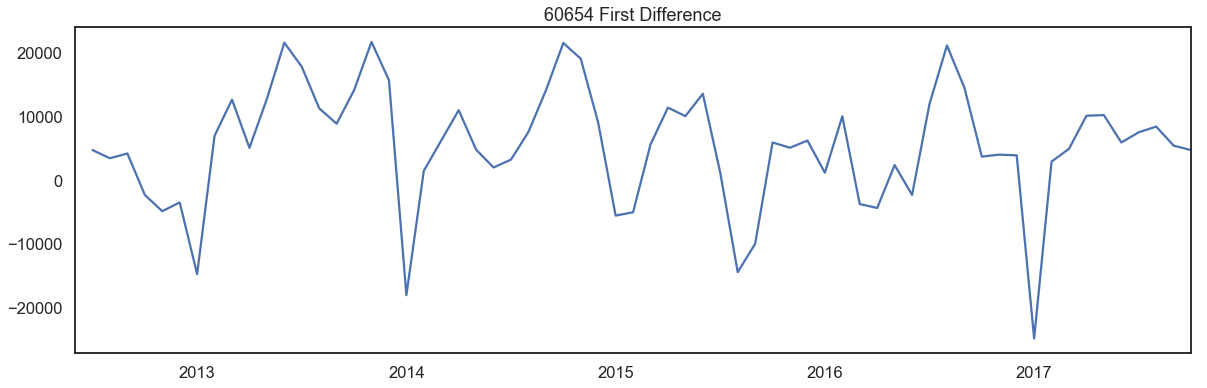

Test Statistic                 -5.085669
p-value                         0.000015
#Lags Used                      1.000000
Number of Observations Used    62.000000
Critical Values 1%             -3.540523
Critical Values 5%             -2.909427
Critical Values 10%            -2.592314
dtype: float64


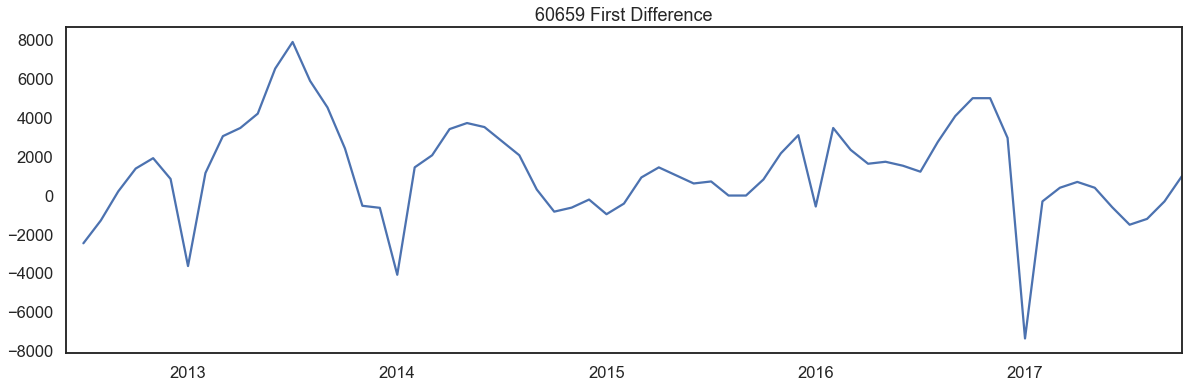

Test Statistic                 -4.273585
p-value                         0.000493
#Lags Used                      0.000000
Number of Observations Used    63.000000
Critical Values 1%             -3.538695
Critical Values 5%             -2.908645
Critical Values 10%            -2.591897
dtype: float64


In [42]:
chicago_df_defl_train_examples = chicago_df_defl_train[[60654, 60659]]
detrend_test(chicago_df_defl_train_examples, suppress_output=True)

* Number of p-values above our alpha of 0.05 was 0
* Some zipcodes required a log first difference
* Due to time constraints we limit this analysis to only those zipcodes that do not requiring logging to detrend.

### Remove zipcodes requiring log first difference (to focus on first difference zipcodes)

In [43]:
# Remove log first difference columns, to focus on first difference columns only
    # NB that log_diff_list are Zipcodes which require a log first difference to transform
chicago_df_defl_train_fd = chicago_df_defl_train.drop(log_diff_list, axis=1)
chicago_df_defl_test_fd  = chicago_df_defl_test.drop(log_diff_list, axis=1)

# ARIMA

## Find best ARIMA model configuration and its RMSE for each zipcode

In [156]:
p_list = [0,1,2,3]
d_list = [1]
q_list = [0,1,2,3]

arima_order_rmse_values = [] # list of tuples, where each tuple is an arima order
for column in list(chicago_df_defl_train_fd.columns):
    print(column) 
    order_value = md.evaluate_models(chicago_df_defl_train_fd[column], test=chicago_df_defl_test_fd[column],
                    p_values= p_list, d_values=d_list, q_values=q_list)
    arima_order_rmse_values.append(order_value)

60657
Best ARIMA (2, 1, 2) RMSE= 4332.080320849668
60614
Best ARIMA (2, 1, 1) RMSE= 11554.335893166302
60640
Best ARIMA (1, 1, 3) RMSE= 7627.558287244174
60647
Best ARIMA (3, 1, 3) RMSE= 4295.602572227894
60618
Best ARIMA (1, 1, 3) RMSE= 6838.58369420071
60613
Best ARIMA (3, 1, 0) RMSE= 5373.036061866304
60629
Best ARIMA (0, 1, 0) RMSE= 812.8917528244916
60625
Best ARIMA (0, 1, 0) RMSE= 5740.267179641704
60619
Best ARIMA (3, 1, 3) RMSE= 2301.617865555815
60610
Best ARIMA (3, 1, 2) RMSE= 13022.256408727539
60611
Best ARIMA (0, 1, 1) RMSE= 7398.863688946469
60620
Best ARIMA (0, 1, 0) RMSE= 2774.0667258955045
60634
Best ARIMA (2, 1, 3) RMSE= 2208.1858982292474
60616
Best ARIMA (2, 1, 2) RMSE= 3346.4817939101144
60615
Best ARIMA (0, 1, 3) RMSE= 5265.635244923485
60641
Best ARIMA (3, 1, 3) RMSE= 1780.8023253880851
60660
Best ARIMA (0, 1, 0) RMSE= 2040.4210525279102
60638
Best ARIMA (2, 1, 3) RMSE= 1687.0263746715436
60639
Best ARIMA (0, 1, 0) RMSE= 2388.1556260883003
60630
Best ARIMA (3, 1,

# Plot Forecasted House Prices

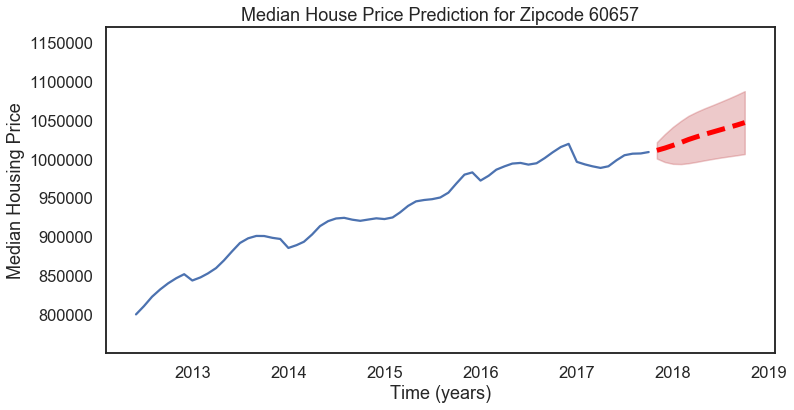

 Final Predicted Price: $1047448.0 
 Total Growth: $37848.0 
 Percentage Growth: 3.75% 
 Risk: 8.03%


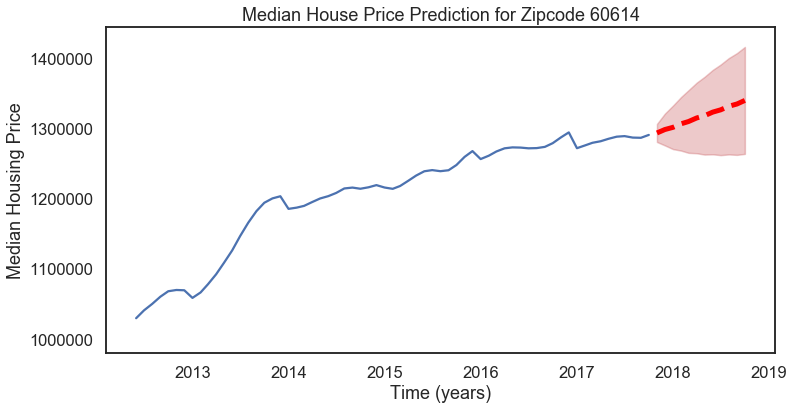

 Final Predicted Price: $1340671.0 
 Total Growth: $49171.0 
 Percentage Growth: 3.81% 
 Risk: 12.05%


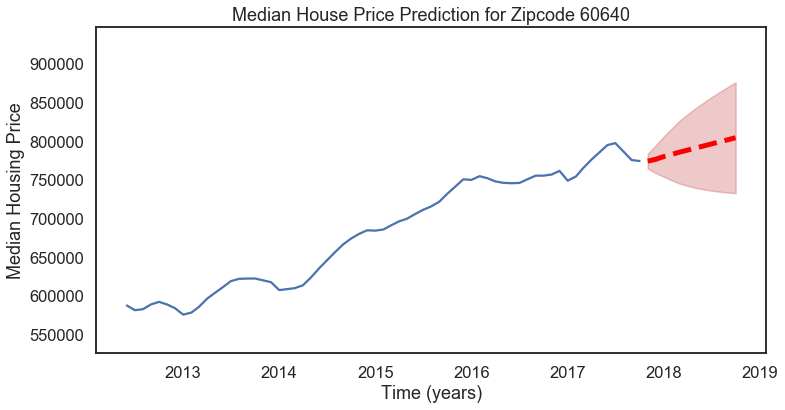

 Final Predicted Price: $804993.0 
 Total Growth: $30093.0 
 Percentage Growth: 3.88% 
 Risk: 19.59%


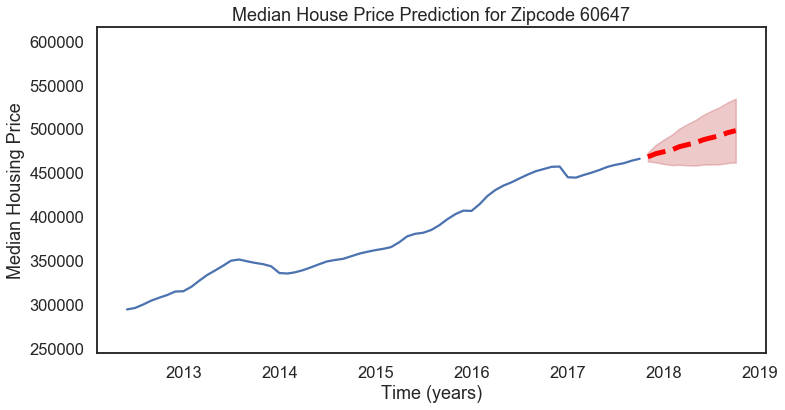

 Final Predicted Price: $498570.0 
 Total Growth: $32070.0 
 Percentage Growth: 6.87% 
 Risk: 15.75%


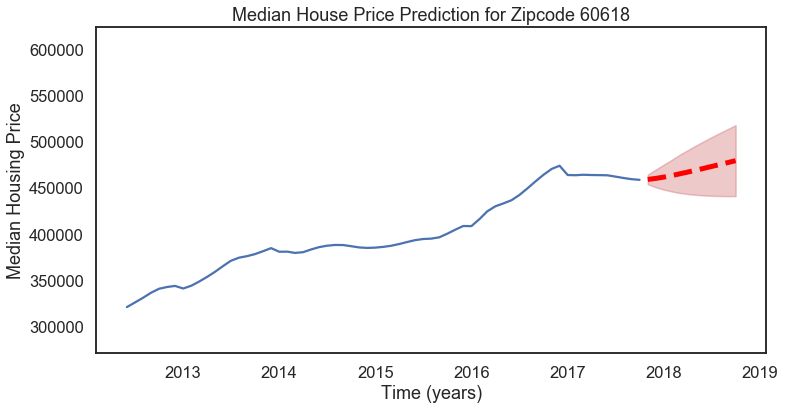

 Final Predicted Price: $479953.0 
 Total Growth: $20753.0 
 Percentage Growth: 4.52% 
 Risk: 17.4%


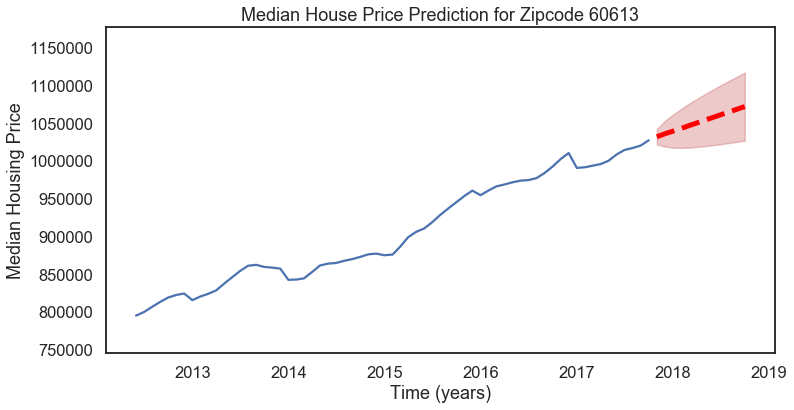

 Final Predicted Price: $1072548.0 
 Total Growth: $44748.0 
 Percentage Growth: 4.35% 
 Risk: 8.77%


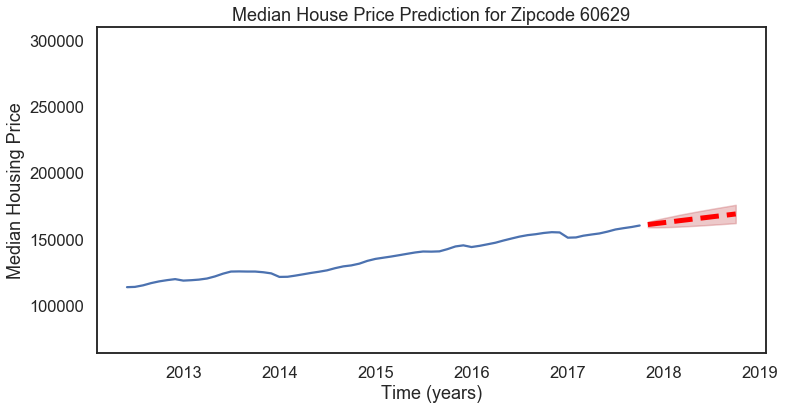

 Final Predicted Price: $169341.0 
 Total Growth: $8741.0 
 Percentage Growth: 5.44% 
 Risk: 8.52%


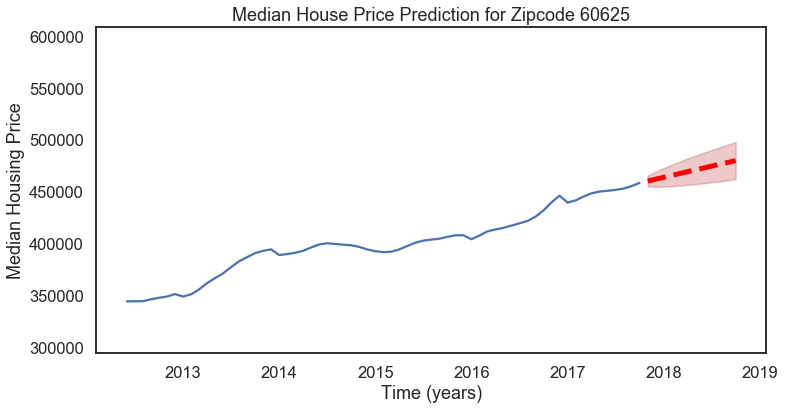

 Final Predicted Price: $480507.0 
 Total Growth: $21407.0 
 Percentage Growth: 4.66% 
 Risk: 7.76%


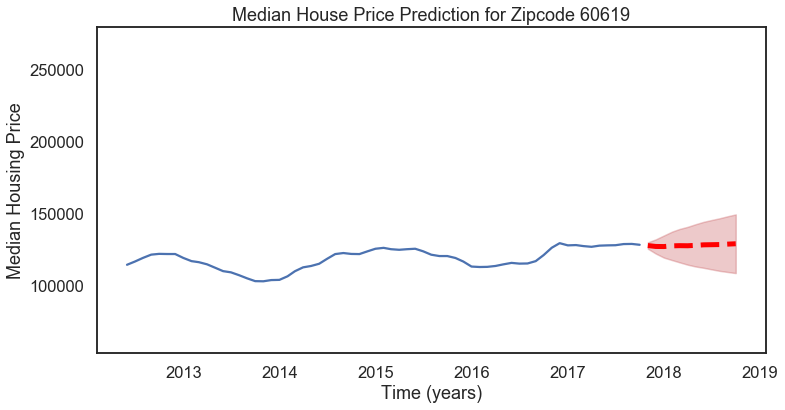

 Final Predicted Price: $129219.0 
 Total Growth: $719.0 
 Percentage Growth: 0.56% 
 Risk: 37.41%


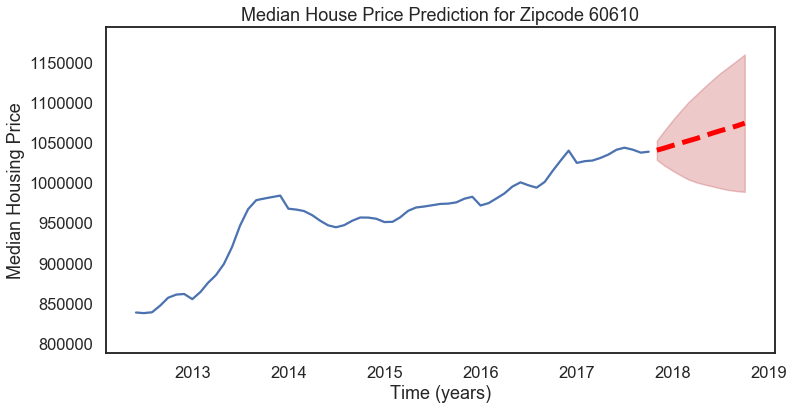

 Final Predicted Price: $1074740.0 
 Total Growth: $35540.0 
 Percentage Growth: 3.42% 
 Risk: 17.27%


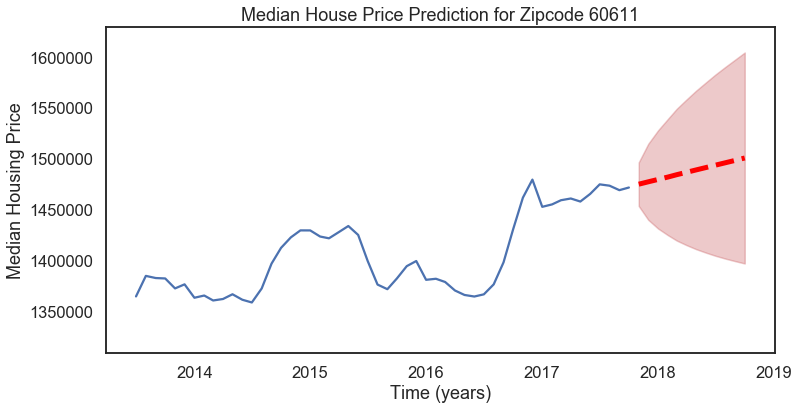

 Final Predicted Price: $1501146.0 
 Total Growth: $29046.0 
 Percentage Growth: 1.97% 
 Risk: 14.85%


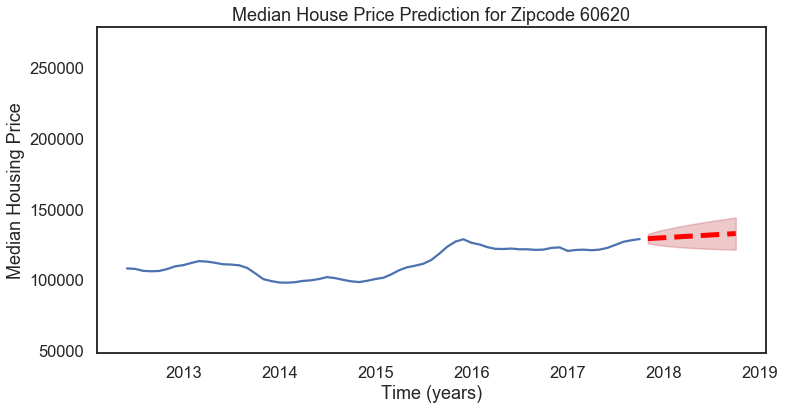

 Final Predicted Price: $132995.0 
 Total Growth: $3895.0 
 Percentage Growth: 3.02% 
 Risk: 18.72%


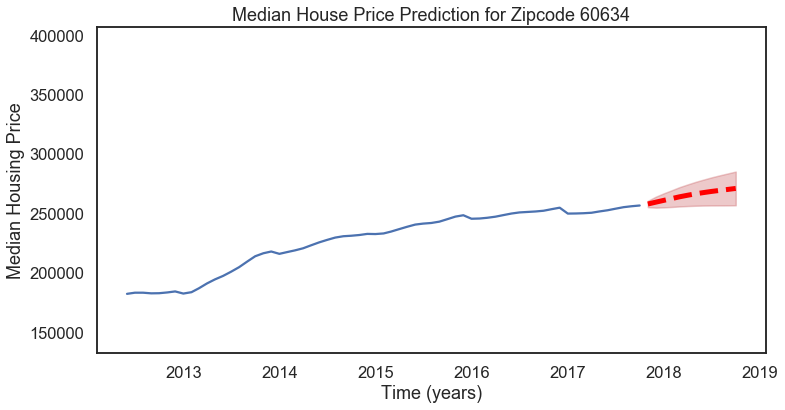

 Final Predicted Price: $271357.0 
 Total Growth: $14357.0 
 Percentage Growth: 5.59% 
 Risk: 11.02%


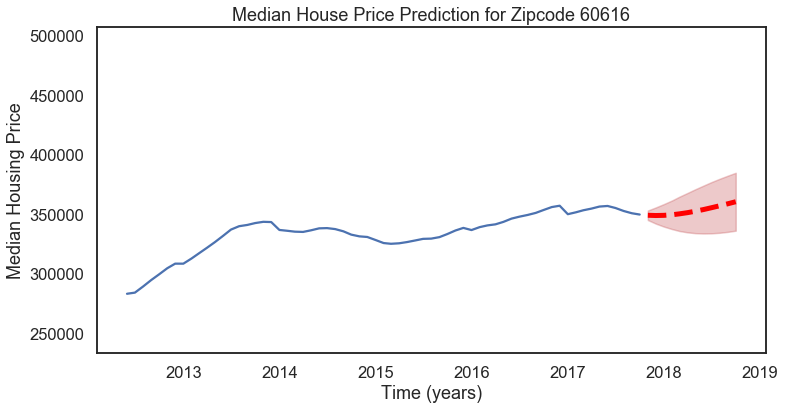

 Final Predicted Price: $360765.0 
 Total Growth: $10765.0 
 Percentage Growth: 3.08% 
 Risk: 14.45%


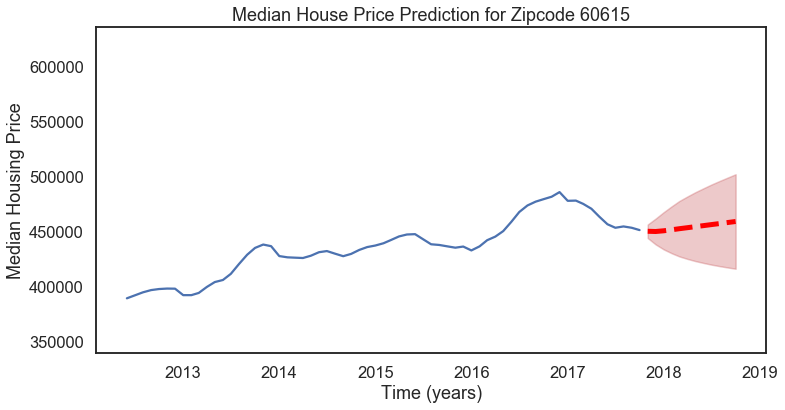

 Final Predicted Price: $459700.0 
 Total Growth: $7800.0 
 Percentage Growth: 1.73% 
 Risk: 20.6%


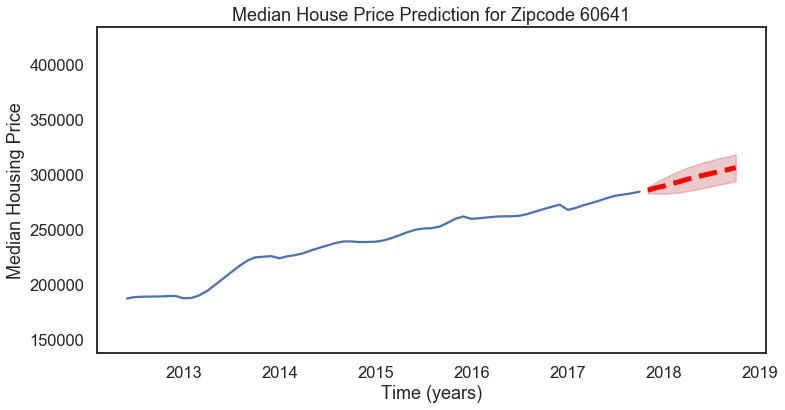

 Final Predicted Price: $306867.0 
 Total Growth: $21967.0 
 Percentage Growth: 7.71% 
 Risk: 8.23%


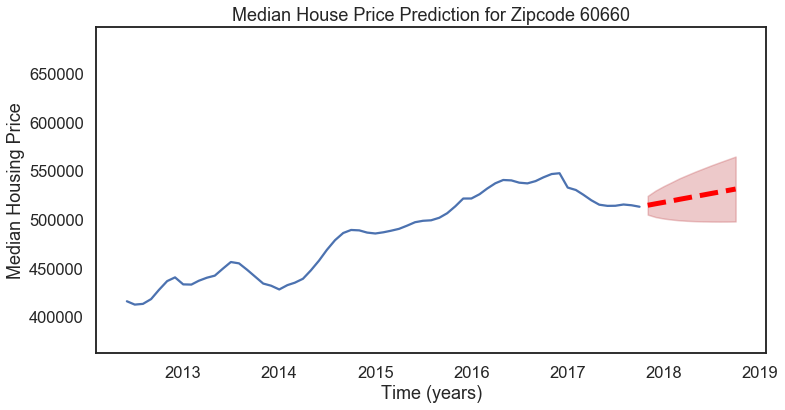

 Final Predicted Price: $531798.0 
 Total Growth: $18198.0 
 Percentage Growth: 3.54% 
 Risk: 13.37%


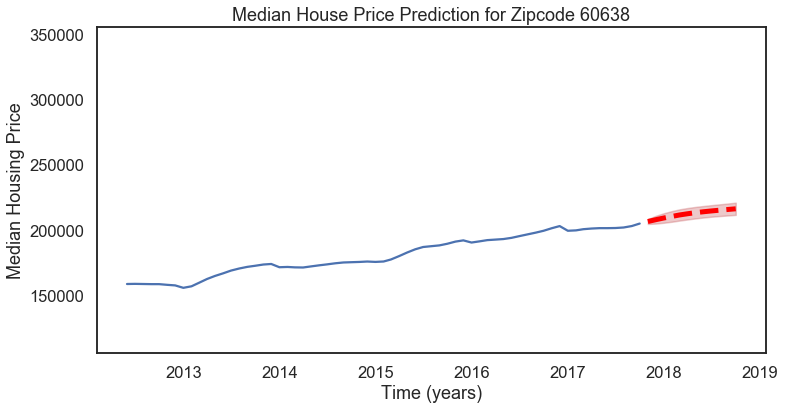

 Final Predicted Price: $216883.0 
 Total Growth: $11283.0 
 Percentage Growth: 5.49% 
 Risk: 4.39%


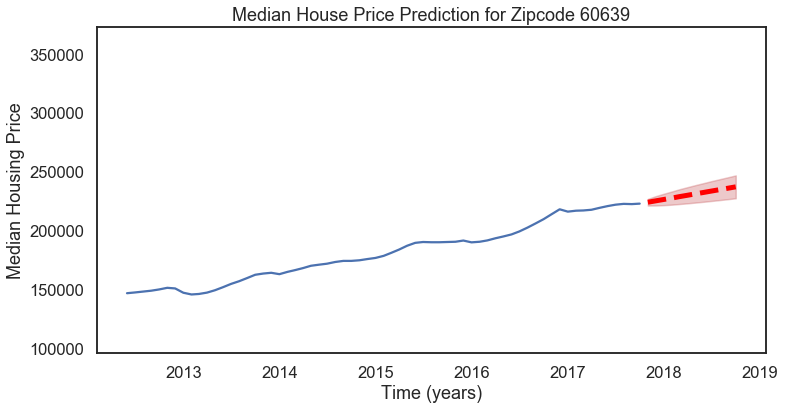

 Final Predicted Price: $237574.0 
 Total Growth: $14274.0 
 Percentage Growth: 6.39% 
 Risk: 8.52%


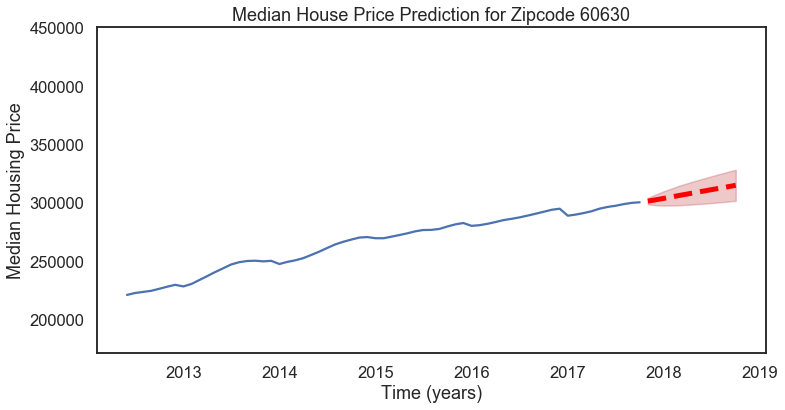

 Final Predicted Price: $315337.0 
 Total Growth: $14537.0 
 Percentage Growth: 4.83% 
 Risk: 8.82%


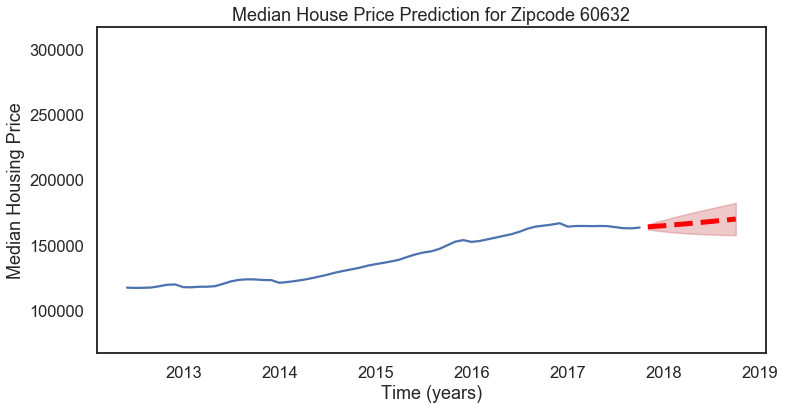

 Final Predicted Price: $170314.0 
 Total Growth: $6514.0 
 Percentage Growth: 3.98% 
 Risk: 15.65%


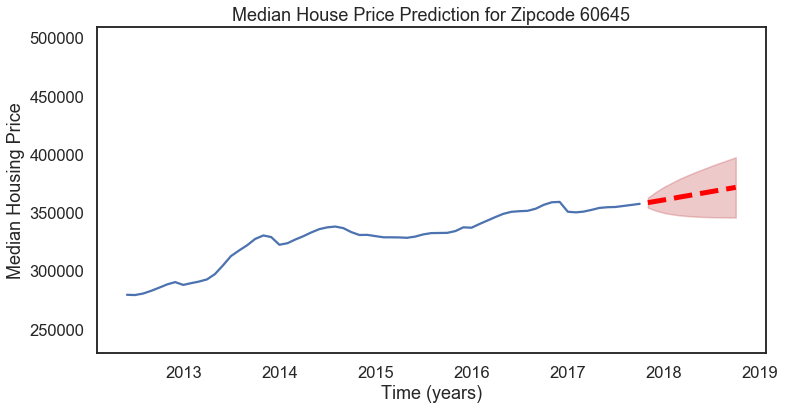

 Final Predicted Price: $372141.0 
 Total Growth: $14141.0 
 Percentage Growth: 3.95% 
 Risk: 14.9%


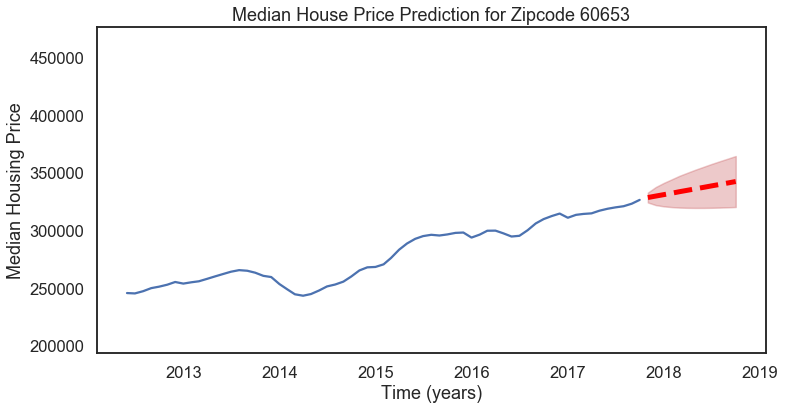

 Final Predicted Price: $342844.0 
 Total Growth: $15944.0 
 Percentage Growth: 4.88% 
 Risk: 13.8%


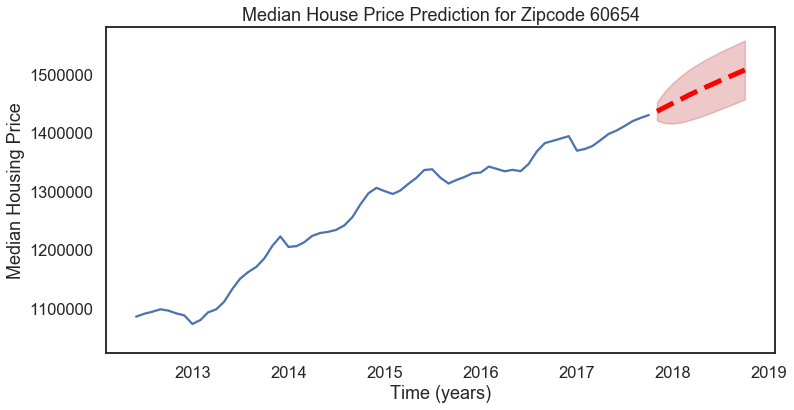

 Final Predicted Price: $1507928.0 
 Total Growth: $76928.0 
 Percentage Growth: 5.38% 
 Risk: 6.89%


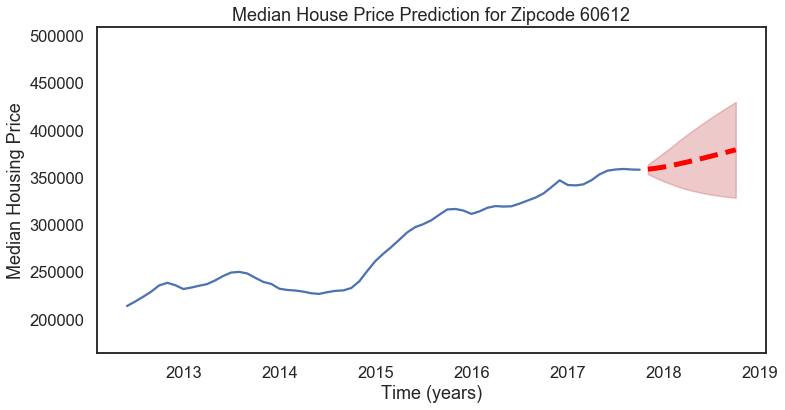

 Final Predicted Price: $379539.0 
 Total Growth: $21039.0 
 Percentage Growth: 5.87% 
 Risk: 30.81%


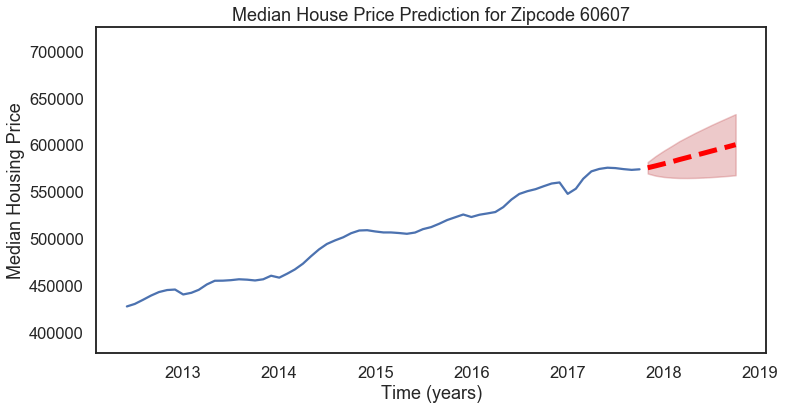

 Final Predicted Price: $600668.0 
 Total Growth: $26268.0 
 Percentage Growth: 4.57% 
 Risk: 11.48%


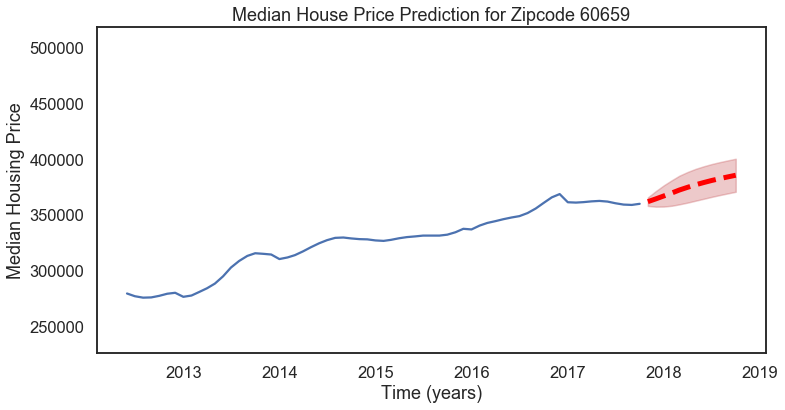

 Final Predicted Price: $385863.0 
 Total Growth: $25663.0 
 Percentage Growth: 7.12% 
 Risk: 7.99%


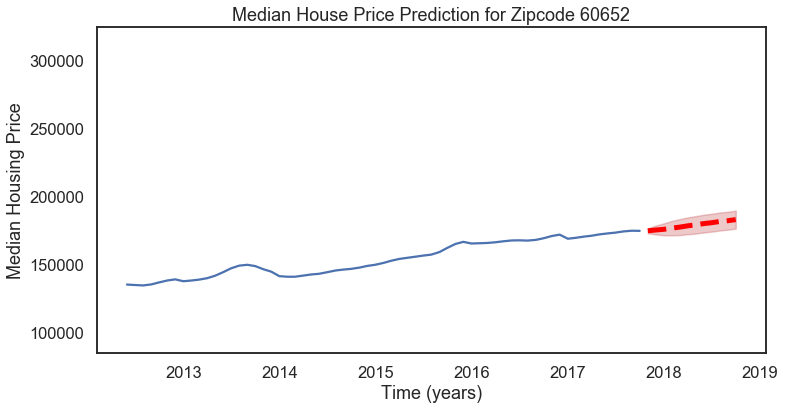

 Final Predicted Price: $183195.0 
 Total Growth: $8295.0 
 Percentage Growth: 4.74% 
 Risk: 7.47%


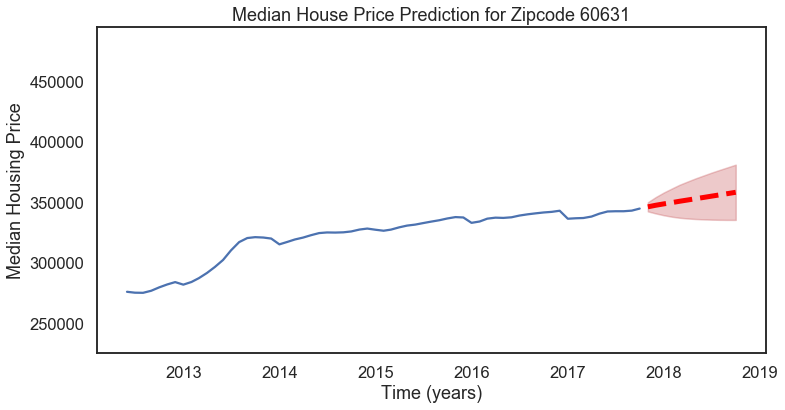

 Final Predicted Price: $358567.0 
 Total Growth: $13467.0 
 Percentage Growth: 3.9% 
 Risk: 13.6%


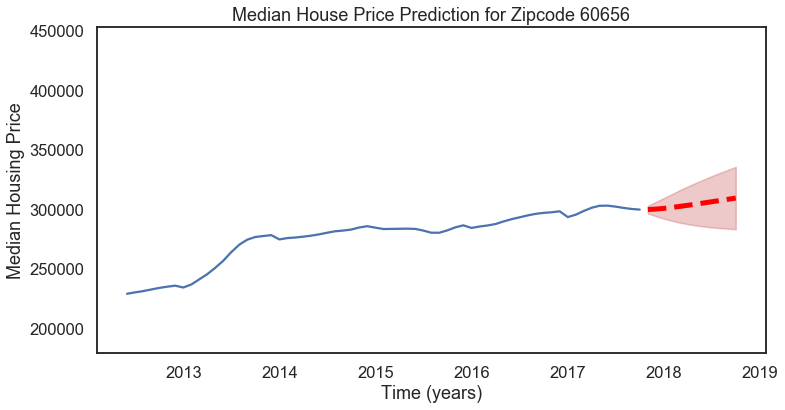

 Final Predicted Price: $309786.0 
 Total Growth: $9686.0 
 Percentage Growth: 3.23% 
 Risk: 18.48%


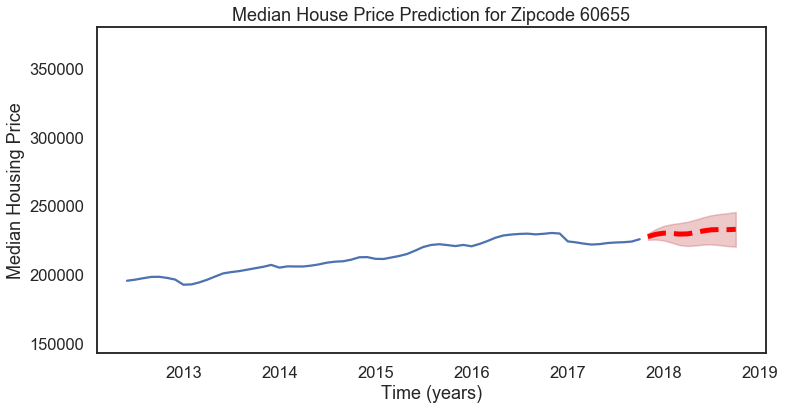

 Final Predicted Price: $233192.0 
 Total Growth: $7192.0 
 Percentage Growth: 3.18% 
 Risk: 11.43%


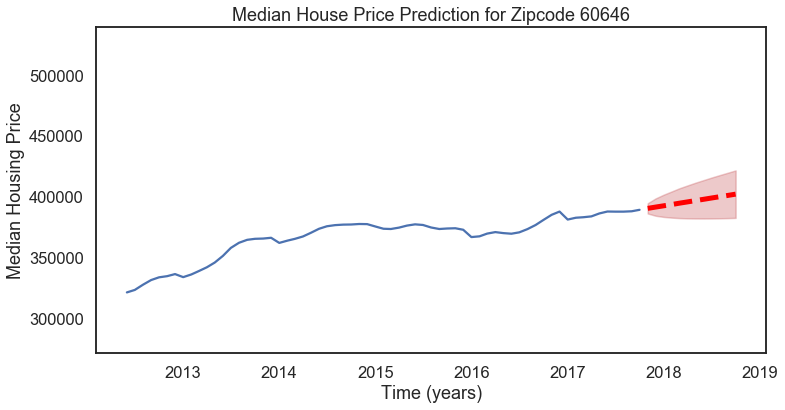

 Final Predicted Price: $402564.0 
 Total Growth: $12864.0 
 Percentage Growth: 3.3% 
 Risk: 10.17%


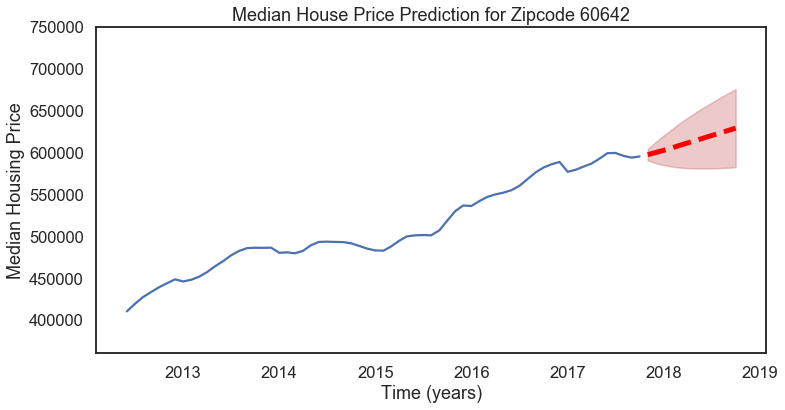

 Final Predicted Price: $629272.0 
 Total Growth: $33772.0 
 Percentage Growth: 5.67% 
 Risk: 16.02%


In [160]:
for i in range(len(chicago_df_defl_train_fd.columns)):
    md.predict_arima_model(chicago_df_defl_train_fd, chicago_df_defl_train_fd.columns[i],
                        arima_order=arima_order_rmse_values[i], periods=12)

## Plot the best zipcodes to invest in

### Plot all best zips

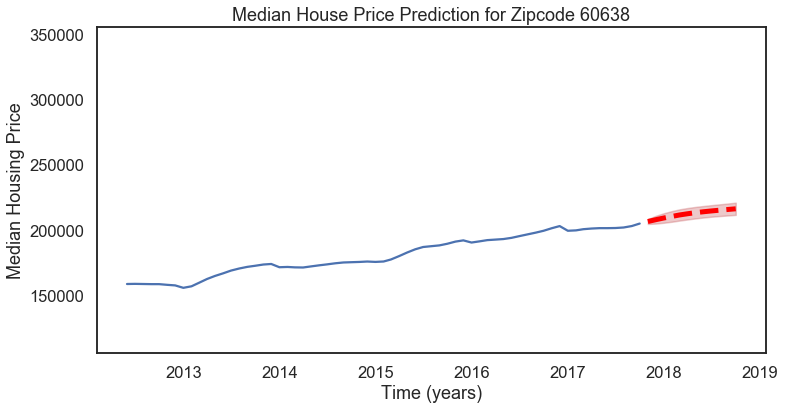

 Final Predicted Price: $216883.0 
 Total Growth: $11283.0 
 Percentage Growth: 5.49% 
 Risk: 4.39%




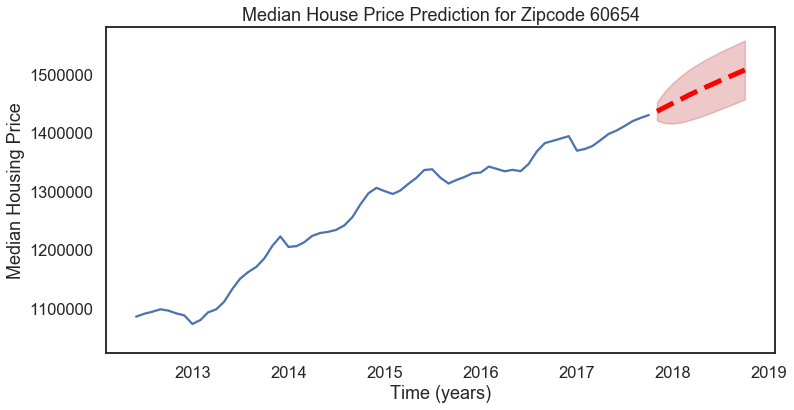

 Final Predicted Price: $1507928.0 
 Total Growth: $76928.0 
 Percentage Growth: 5.38% 
 Risk: 6.89%




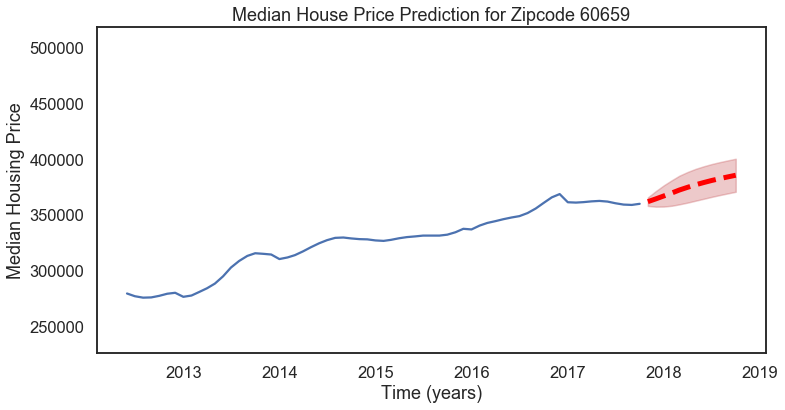

 Final Predicted Price: $385863.0 
 Total Growth: $25663.0 
 Percentage Growth: 7.12% 
 Risk: 7.99%




In [162]:
final_zips = ['60638','60654', '60659']
for zipcode, order in zip(chicago_df_defl_train_fd.columns,arima_order_rmse_values):
    if (str(zipcode) in final_zips):
        md.predict_arima_model(chicago_df_defl_train_fd, zipcode, order, 12)
        print('\n')
# plt.title('Median House Price Prediction for Zipcode')
# plt.legend(loc=2)
# plt.savefig('../reports/figures/best_zips_predictions.png')

## Baseline Model

In [195]:
chicago_defl_fd = pd.concat([chicago_df_defl_train, chicago_df_defl_test], axis=0)
for code in [60638, 60654, 60659]:
    update = chicago_df_defl_train[code]
    
    for t in range(len(chicago_df_defl_test)):
        rolmean = update.rolling(window = 3, center = False).mean()
        yhat = rolmean.iloc[-1].item()
        date = chicago_df_defl_test.index[t]
        series = pd.DataFrame([[yhat]], index=[date])
        update = update.append(series)
    diff = update.iloc[-6:,0] - chicago_defl_fd[code].iloc[-6:]
    RMSE = np.sqrt(sum((diff)**2)/len(diff))
    print(code, "RMSE: ",RMSE)

60638 RMSE:  4095.378338245403
60654 RMSE:  12760.567817870256
60659 RMSE:  3053.396523452349


# Our Model

60638 RMSE: 1687.0263746715436

60654 RMSE: 7102.839341275809

60659 RMSE: 1964.6721989819027